<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Datos_prueba_3%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

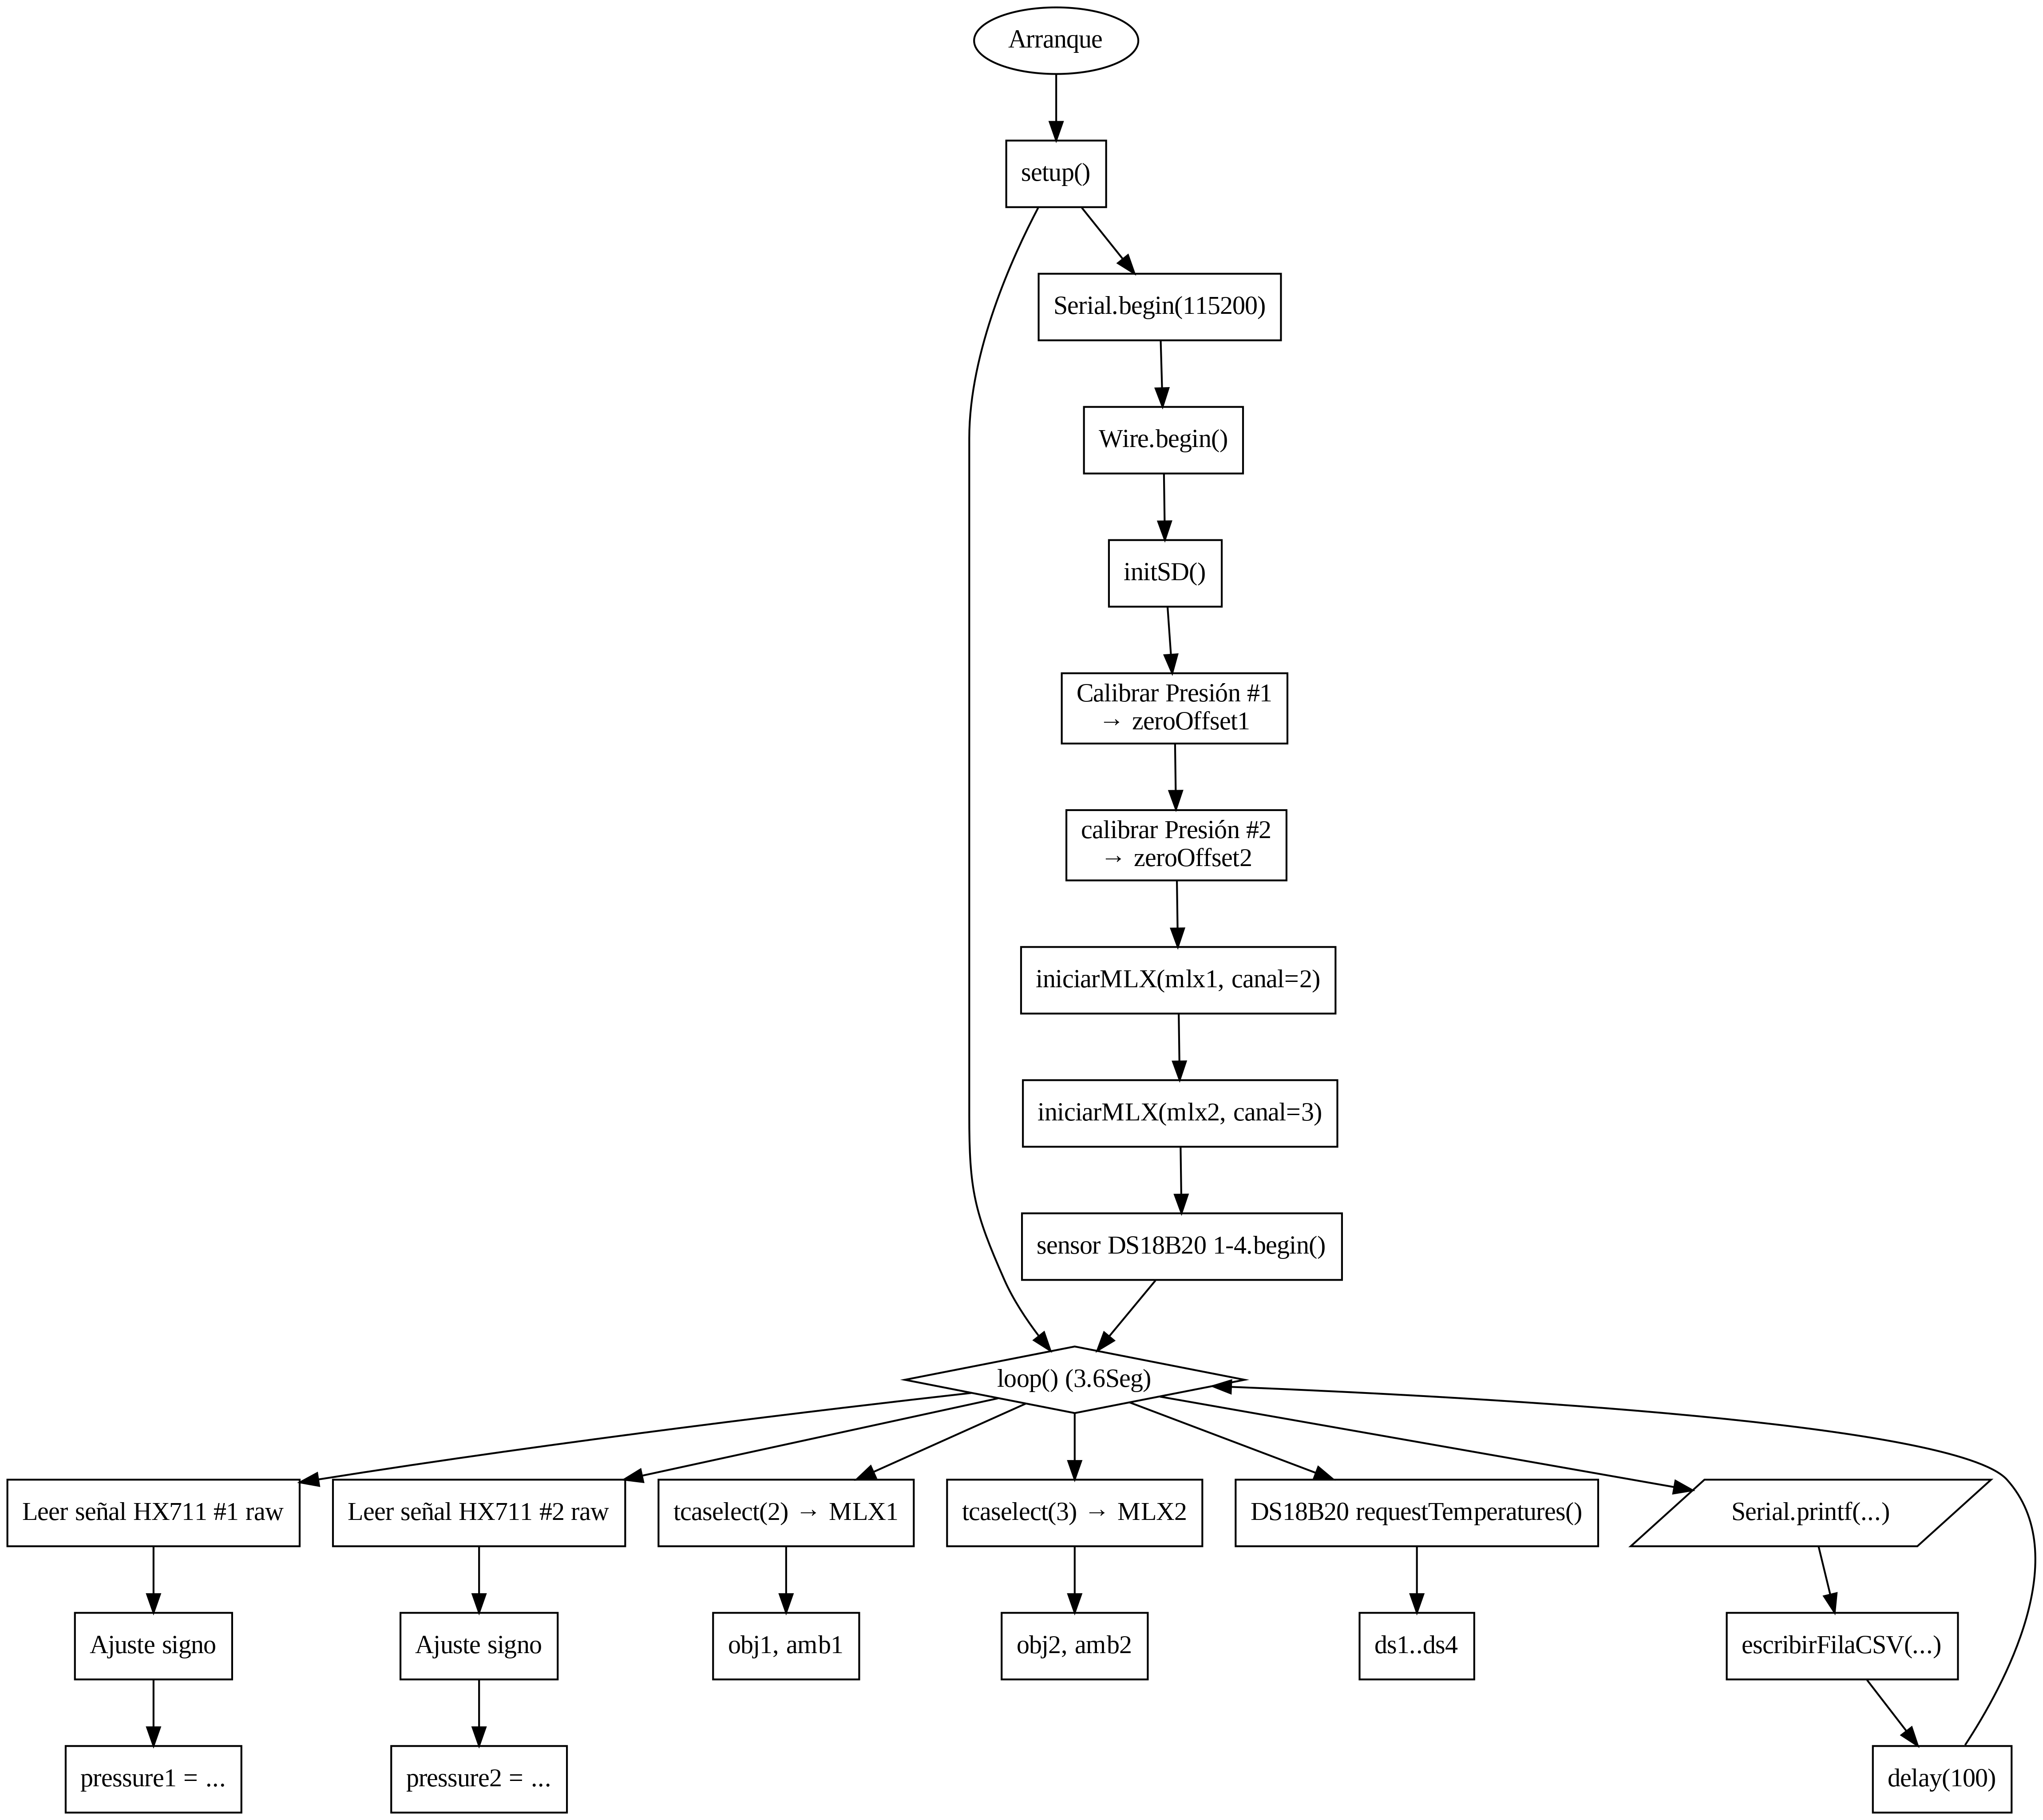

In [1]:
!apt-get -qq install graphviz > /dev/null
!pip install graphviz > /dev/null

from graphviz import Digraph
from IPython.display import Image

dot = Digraph(comment="Diagrama de flujo del logger", format='png')

dot.attr(rankdir='TB')
dot.attr(size='20')
dot.attr(dpi='300')
dot.attr(fontname="Helvetica")

# Nodos principales
dot.node("A", "Arranque", shape="ellipse")
dot.node("B", "setup()", shape="box")
dot.node("C", "loop() (3.6Seg)", shape="diamond")

# Setup
dot.edge("A", "B")
dot.edge("B", "C")
dot.node("B1", "Serial.begin(115200)", shape="box")
dot.node("B2", "Wire.begin()", shape="box")
dot.node("B3", "initSD()", shape="box")
dot.node("B4", "Calibrar Presión #1\n→ zeroOffset1", shape="box")
dot.node("B5", "calibrar Presión #2\n→ zeroOffset2", shape="box")
dot.node("B6", "iniciarMLX(mlx1, canal=2)", shape="box")
dot.node("B7", "iniciarMLX(mlx2, canal=3)", shape="box")
dot.node("B8", "sensor DS18B20 1-4.begin()", shape="box")

dot.edges([("B","B1"),("B1","B2"),("B2","B3"),("B3","B4"),
           ("B4","B5"),("B5","B6"),("B6","B7"),("B7","B8"),("B8","C")])

# Loop interno
dot.node("D1", "Leer señal HX711 #1 raw", shape="box")
dot.node("D2", "Ajuste signo", shape="box")
dot.node("D3", "pressure1 = ...", shape="box")

dot.node("E1", "Leer señal HX711 #2 raw", shape="box")
dot.node("E2", "Ajuste signo", shape="box")
dot.node("E3", "pressure2 = ...", shape="box")

dot.node("F1", "tcaselect(2) → MLX1", shape="box")
dot.node("F2", "obj1, amb1", shape="box")

dot.node("G1", "tcaselect(3) → MLX2", shape="box")
dot.node("G2", "obj2, amb2", shape="box")

dot.node("H1", "DS18B20 requestTemperatures()", shape="box")
dot.node("H2", "ds1..ds4", shape="box")

dot.node("I", "Serial.printf(...)", shape="parallelogram")
dot.node("J", "escribirFilaCSV(...)", shape="box")
dot.node("K", "delay(100)", shape="box")

# Relaciones loop
dot.edges([("C","D1"),("D1","D2"),("D2","D3")])
dot.edges([("C","E1"),("E1","E2"),("E2","E3")])
dot.edges([("C","F1"),("F1","F2")])
dot.edges([("C","G1"),("G1","G2")])
dot.edges([("C","H1"),("H1","H2")])
dot.edge("C","I")
dot.edge("I","J")
dot.edge("J","K")
dot.edge("K","C")

output_path = "diagrama_logger"
dot.render(output_path, format="png", cleanup=True)
Image(filename=output_path + ".png")


In [2]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# === Configura aquí ===
INPUT_PATH  = "serial_log_parte1.csv"
OUTPUT_PATH = "salida1.csv"
CLIP_NEGATIVES = True   # True => si una hora retrocede, dt_s=0 y elapsed no disminuye

# --- Patrones regex ---
TS_RE = re.compile(r'^(?P<ts>\d{2}:\d{2}:\d{2}[.,]\d{3})\s*->\s*(?P<rest>.*)$')

PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)
IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == 'nan' or x == '':
        return float('nan')
    try:
        return float(x)
    except ValueError:
        return float('nan')

def parse_file(text_lines):
    """
    Devuelve una lista de dicts, 1 por bloque.
    Cada bloque se ancla en la línea 'Presiones:' y hereda ese timestamp.
    """
    blocks = []
    cur = None

    def finalize_current():
        nonlocal cur
        if cur is not None:
            blocks.append(cur)
            cur = None

    for raw in text_lines:
        line = raw.rstrip('\n')
        if not line.strip():
            continue

        m = TS_RE.match(line)
        if not m:
            # separador fuera de formato con timestamp
            if SEP_RE.match(line):
                finalize_current()
            continue

        ts = m.group('ts').replace(',', '.')  # normaliza coma decimal si existiera
        rest = m.group('rest')

        # separador con timestamp
        if SEP_RE.match(rest):
            finalize_current()
            continue

        # Inicio de bloque: Presiones
        mp = PRESS_RE.search(rest)
        if mp:
            finalize_current()
            cur = {
                'time': ts,  # se conserva tal cual
                'P1_mmHg': to_float(mp.group(1)),
                'P2_mmHg': to_float(mp.group(2)),
                'IR2_Obj_C': float('nan'),
                'IR2_Amb_C': float('nan'),
                'IR3_Obj_C': float('nan'),
                'IR3_Amb_C': float('nan'),
                'DS_T1_C': float('nan'),
                'DS_T2_C': float('nan'),
                'DS_T3_C': float('nan'),
                'DS_T4_C': float('nan'),
            }
            continue

        # Si no hay bloque iniciado, ignora
        if cur is None:
            continue

        # IR Canal X
        mi = IR_RE.search(rest)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == '2':
                cur['IR2_Obj_C'] = obj
                cur['IR2_Amb_C'] = amb
            elif canal == '3':
                cur['IR3_Obj_C'] = obj
                cur['IR3_Amb_C'] = amb
            continue

        # DS18B20
        md = DS_RE.search(rest)
        if md:
            cur['DS_T1_C'] = to_float(md.group(1))
            cur['DS_T2_C'] = to_float(md.group(2))
            cur['DS_T3_C'] = to_float(md.group(3))
            cur['DS_T4_C'] = to_float(md.group(4))
            continue

    # Fin de archivo
    finalize_current()
    return blocks

def compute_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula dt_s y elapsed_s siguiendo ESTRICTAMENTE el orden del archivo:
      - time: se conserva tal cual (HH:MM:SS.mmm).
      - dt_s: diferencia vs. la fila anterior (en s), sin reordenar ni detectar medianoche.
      - elapsed_s: suma acumulada de dt_s (arranca en 0).
    """
    # Normaliza solo para parseo
    t_str = df['time'].astype(str).str.replace(',', '.', regex=False)

    def hms_to_seconds(hms: str) -> float:
        h, m, s = hms.split(':')
        return int(h)*3600 + int(m)*60 + float(s)

    secs = t_str.apply(hms_to_seconds).to_numpy(dtype=float)

    # Diferencias consecutivas en el ORDEN de las filas
    dt = np.diff(secs, prepend=secs[0])

    # Si alguna marca retrocede y quieres monotonicidad, recorta a 0
    if CLIP_NEGATIVES:
        dt = np.maximum(dt, 0.0)

    elapsed = np.cumsum(dt)
    elapsed[0] = 0.0

    df['elapsed_s'] = elapsed.astype(float)
    df['dt_s'] = dt.astype(float)
    return df

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo de entrada: {p.resolve()}")
    with p.open('r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    blocks = parse_file(lines)
    if not blocks:
        raise RuntimeError("No se pudieron extraer bloques. ¿El formato coincide con los ejemplos?")

    df = pd.DataFrame(blocks, columns=[
        'time','P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ])

    df = compute_times(df)

    # Orden final homogéneo
    cols = [
        'time','elapsed_s','dt_s',
        'P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ]
    df = df[cols]

    df.to_csv(out_path, index=False, encoding='utf-8', float_format='%.3f')
    print(f"Listo. Se escribió el CSV limpio en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


Listo. Se escribió el CSV limpio en: /content/salida1.csv


In [3]:

import re
from pathlib import Path
import pandas as pd
import numpy as np

# === Configura aquí ===
INPUT_PATH  = "serial_log_parte2.csv"   # CSV con: seq, iso_ts, mensaje
OUTPUT_PATH = "salida2.csv"             # CSV limpio de salida

# --- Offsets solicitados ---
OFFSETS = {
    "P1_mmHg": 10.600,
    "P2_mmHg": 174.000,
    "elapsed_s": 24001.140,  # <- clave corregida: elapsed_s
}

# Offset global (todas las numéricas)
GLOBAL_OFFSET = 0.0

# Filtros para aplicar (deja en None si quieres que aplique a TODO)
ROW_INDEX_RANGE = None         # (inicio, fin) por índice, inclusivo. Ej.: (100, 500)
ELAPSED_RANGE_S = None         # (t0, t1) en segundos. Ej.: (30.0, 120.0)
TIME_RANGE_HMS  = None         # ("HH:MM:SS.mmm", "HH:MM:SS.mmm")

# Calcular tiempo: recortar negativos en dt (monotonía)
CLIP_NEGATIVES = True

# --- Patrones ---
PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)
IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == "nan" or x == "":
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

def iso_to_parts(iso_str: str):
    """
    Devuelve:
      - dt (datetime64[ns]) de pandas
      - time_str: 'HH:MM:SS.mmm'
    """
    dt = pd.to_datetime(iso_str, utc=False, errors="raise")
    time_str = dt.strftime("%H:%M:%S.") + f"{int(dt.microsecond/1000):03d}"
    return dt, time_str

def parse_blocks(df_raw: pd.DataFrame) -> list[dict]:
    """
    Recorre el CSV (en el orden del archivo por 'seq') y arma bloques
    anclados a la línea 'Presiones'. Cada bloque hereda su timestamp de esa línea.
    """
    blocks = []
    cur = None

    for _, row in df_raw.sort_values("seq").iterrows():
        msg = str(row["mensaje"]).strip()
        iso = str(row["iso_ts"]).strip()

        # Cierre por separador
        if SEP_RE.match(msg):
            if cur is not None:
                blocks.append(cur)
                cur = None
            continue

        # Inicio de bloque: Presiones
        mp = PRESS_RE.search(msg)
        if mp:
            if cur is not None:
                blocks.append(cur)

            dt, time_str = iso_to_parts(iso)
            cur = {
                "seq": int(row["seq"]) if pd.notna(row["seq"]) else None,
                "time": time_str,  # HH:MM:SS.mmm (se usará para el tiempo)
                "P1_mmHg": to_float(mp.group(1)),
                "P2_mmHg": to_float(mp.group(2)),
                "IR2_Obj_C": np.nan, "IR2_Amb_C": np.nan,
                "IR3_Obj_C": np.nan, "IR3_Amb_C": np.nan,
                "DS_T1_C": np.nan, "DS_T2_C": np.nan, "DS_T3_C": np.nan, "DS_T4_C": np.nan,
            }
            continue

        # Si no hay bloque iniciado, ignora
        if cur is None:
            continue

        # IR
        mi = IR_RE.search(msg)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == "2":
                cur["IR2_Obj_C"] = obj
                cur["IR2_Amb_C"] = amb
            elif canal == "3":
                cur["IR3_Obj_C"] = obj
                cur["IR3_Amb_C"] = amb
            continue

        # DS18B20
        md = DS_RE.search(msg)
        if md:
            cur["DS_T1_C"] = to_float(md.group(1))
            cur["DS_T2_C"] = to_float(md.group(2))
            cur["DS_T3_C"] = to_float(md.group(3))
            cur["DS_T4_C"] = to_float(md.group(4))
            continue

    if cur is not None:
        blocks.append(cur)
    return blocks

def compute_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula dt_s y elapsed_s estrictamente en el ORDEN del archivo:
      - 'time' se conserva tal cual (HH:MM:SS.mmm).
      - dt_s = diferencia vs. fila anterior (en s), sin reordenar ni detectar medianoche.
      - elapsed_s = suma acumulada de dt_s (arranca en 0).
    """
    # Orden por 'seq' si existe (mantenemos orden del archivo)
    if 'seq' in df.columns:
        df = df.sort_values('seq').reset_index(drop=True)

    # Normaliza solo para parseo (NO modifica df['time'])
    t_str = df['time'].astype(str).str.replace(',', '.', regex=False)

    def hms_to_seconds(hms: str) -> float:
        h, m, s = hms.split(':')
        return int(h)*3600 + int(m)*60 + float(s)

    secs = t_str.apply(hms_to_seconds).to_numpy(dtype=float)

    # Diferencias consecutivas
    dt = np.diff(secs, prepend=secs[0])
    if CLIP_NEGATIVES:
        dt = np.maximum(dt, 0.0)

    elapsed = np.cumsum(dt)
    elapsed[0] = 0.0

    df['elapsed_s'] = elapsed.astype(float)
    df['dt_s'] = dt.astype(float)

    # quita 'seq' si no la quieres en salida
    if 'seq' in df.columns:
        df = df.drop(columns=['seq'])

    return df

def _mask_for_corrections(df: pd.DataFrame) -> pd.Series:
    """Máscara booleana para delimitar dónde aplicar las correcciones."""
    mask = pd.Series(True, index=df.index)

    if ROW_INDEX_RANGE is not None:
        i0, i1 = ROW_INDEX_RANGE
        mask &= (df.index >= i0) & (df.index <= i1)

    if ELAPSED_RANGE_S is not None and "elapsed_s" in df.columns:
        e0, e1 = ELAPSED_RANGE_S
        mask &= (df["elapsed_s"] >= e0) & (df["elapsed_s"] <= e1)

    if TIME_RANGE_HMS is not None and "time" in df.columns:
        t0, t1 = TIME_RANGE_HMS
        mask &= (df["time"] >= t0) & (df["time"] <= t1)

    return mask

def apply_corrections(df: pd.DataFrame) -> pd.DataFrame:
    """Aplica offsets por columna y/u offset global según filtros; si cambia elapsed_s, recalcula dt_s."""
    df = df.copy()
    mask = _mask_for_corrections(df)

    changed_elapsed = False

    # Offsets por columna
    for col, delta in OFFSETS.items():
        if col in df.columns and np.isfinite(delta) and float(delta) != 0.0:
            vals = pd.to_numeric(df.loc[mask, col], errors="coerce")
            df.loc[mask, col] = vals + float(delta)
            if col == "elapsed_s":
                changed_elapsed = True

    # Offset global
    if GLOBAL_OFFSET and np.isfinite(GLOBAL_OFFSET):
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        for col in num_cols:
            vals = pd.to_numeric(df.loc[mask, col], errors="coerce")
            df.loc[mask, col] = vals + float(GLOBAL_OFFSET)
            if col == "elapsed_s":
                changed_elapsed = True

    # Si tocamos elapsed_s, recalcular dt_s
    if changed_elapsed and "elapsed_s" in df.columns:
        df["dt_s"] = pd.to_numeric(df["elapsed_s"], errors="coerce").diff().fillna(0.0)

    return df

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {p.resolve()}")

    # Lee 3 columnas: seq, iso_ts, mensaje
    df_raw = pd.read_csv(
        p,
        header=None,
        names=["seq", "iso_ts", "mensaje"],
        dtype={"seq": "Int64", "iso_ts": str, "mensaje": str},
        keep_default_na=False,
        encoding="utf-8",
        engine="python"
    )

    blocks = parse_blocks(df_raw)
    if not blocks:
        raise RuntimeError("No se detectaron bloques con 'Presiones'.")

    df = pd.DataFrame(blocks)

    # Tiempo secuencial por 'time' en el orden del archivo
    df = compute_time_cols(df)

    # Columnas homogéneas
    cols = [
        "time", "elapsed_s", "dt_s",
        "P1_mmHg", "P2_mmHg",
        "IR2_Obj_C", "IR2_Amb_C", "IR3_Obj_C", "IR3_Amb_C",
        "DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"
    ]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    df = df[cols]

    # Aplica tus correcciones (incluye elapsed_s)
    df = apply_corrections(df)

    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"CSV escrito en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


CSV escrito en: /content/salida2.csv


In [4]:
import pandas as pd
from pathlib import Path

# === Configura aquí ===
CSV1 = "salida1.csv"   # primer CSV
CSV2 = "salida2.csv"   # segundo CSV
OUTPUT = "salida_unida.csv"

def unir_csvs(csv1, csv2, out_path=OUTPUT):
    # Cargar ambos
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Tomar solo columnas en común
    common_cols = [c for c in df1.columns if c in df2.columns]
    df1 = df1[common_cols]
    df2 = df2[common_cols]

    # Concatenar tal cual (sin reordenar ni recalcular)
    df = pd.concat([df1, df2], ignore_index=True)

    # Guardar
    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"Archivo combinado guardado en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    unir_csvs(CSV1, CSV2, OUTPUT)

Archivo combinado guardado en: /content/salida_unida.csv


/tmp/ipython-input-3105832059.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start = pd.to_datetime(x_dt.iloc[0]).round('S')


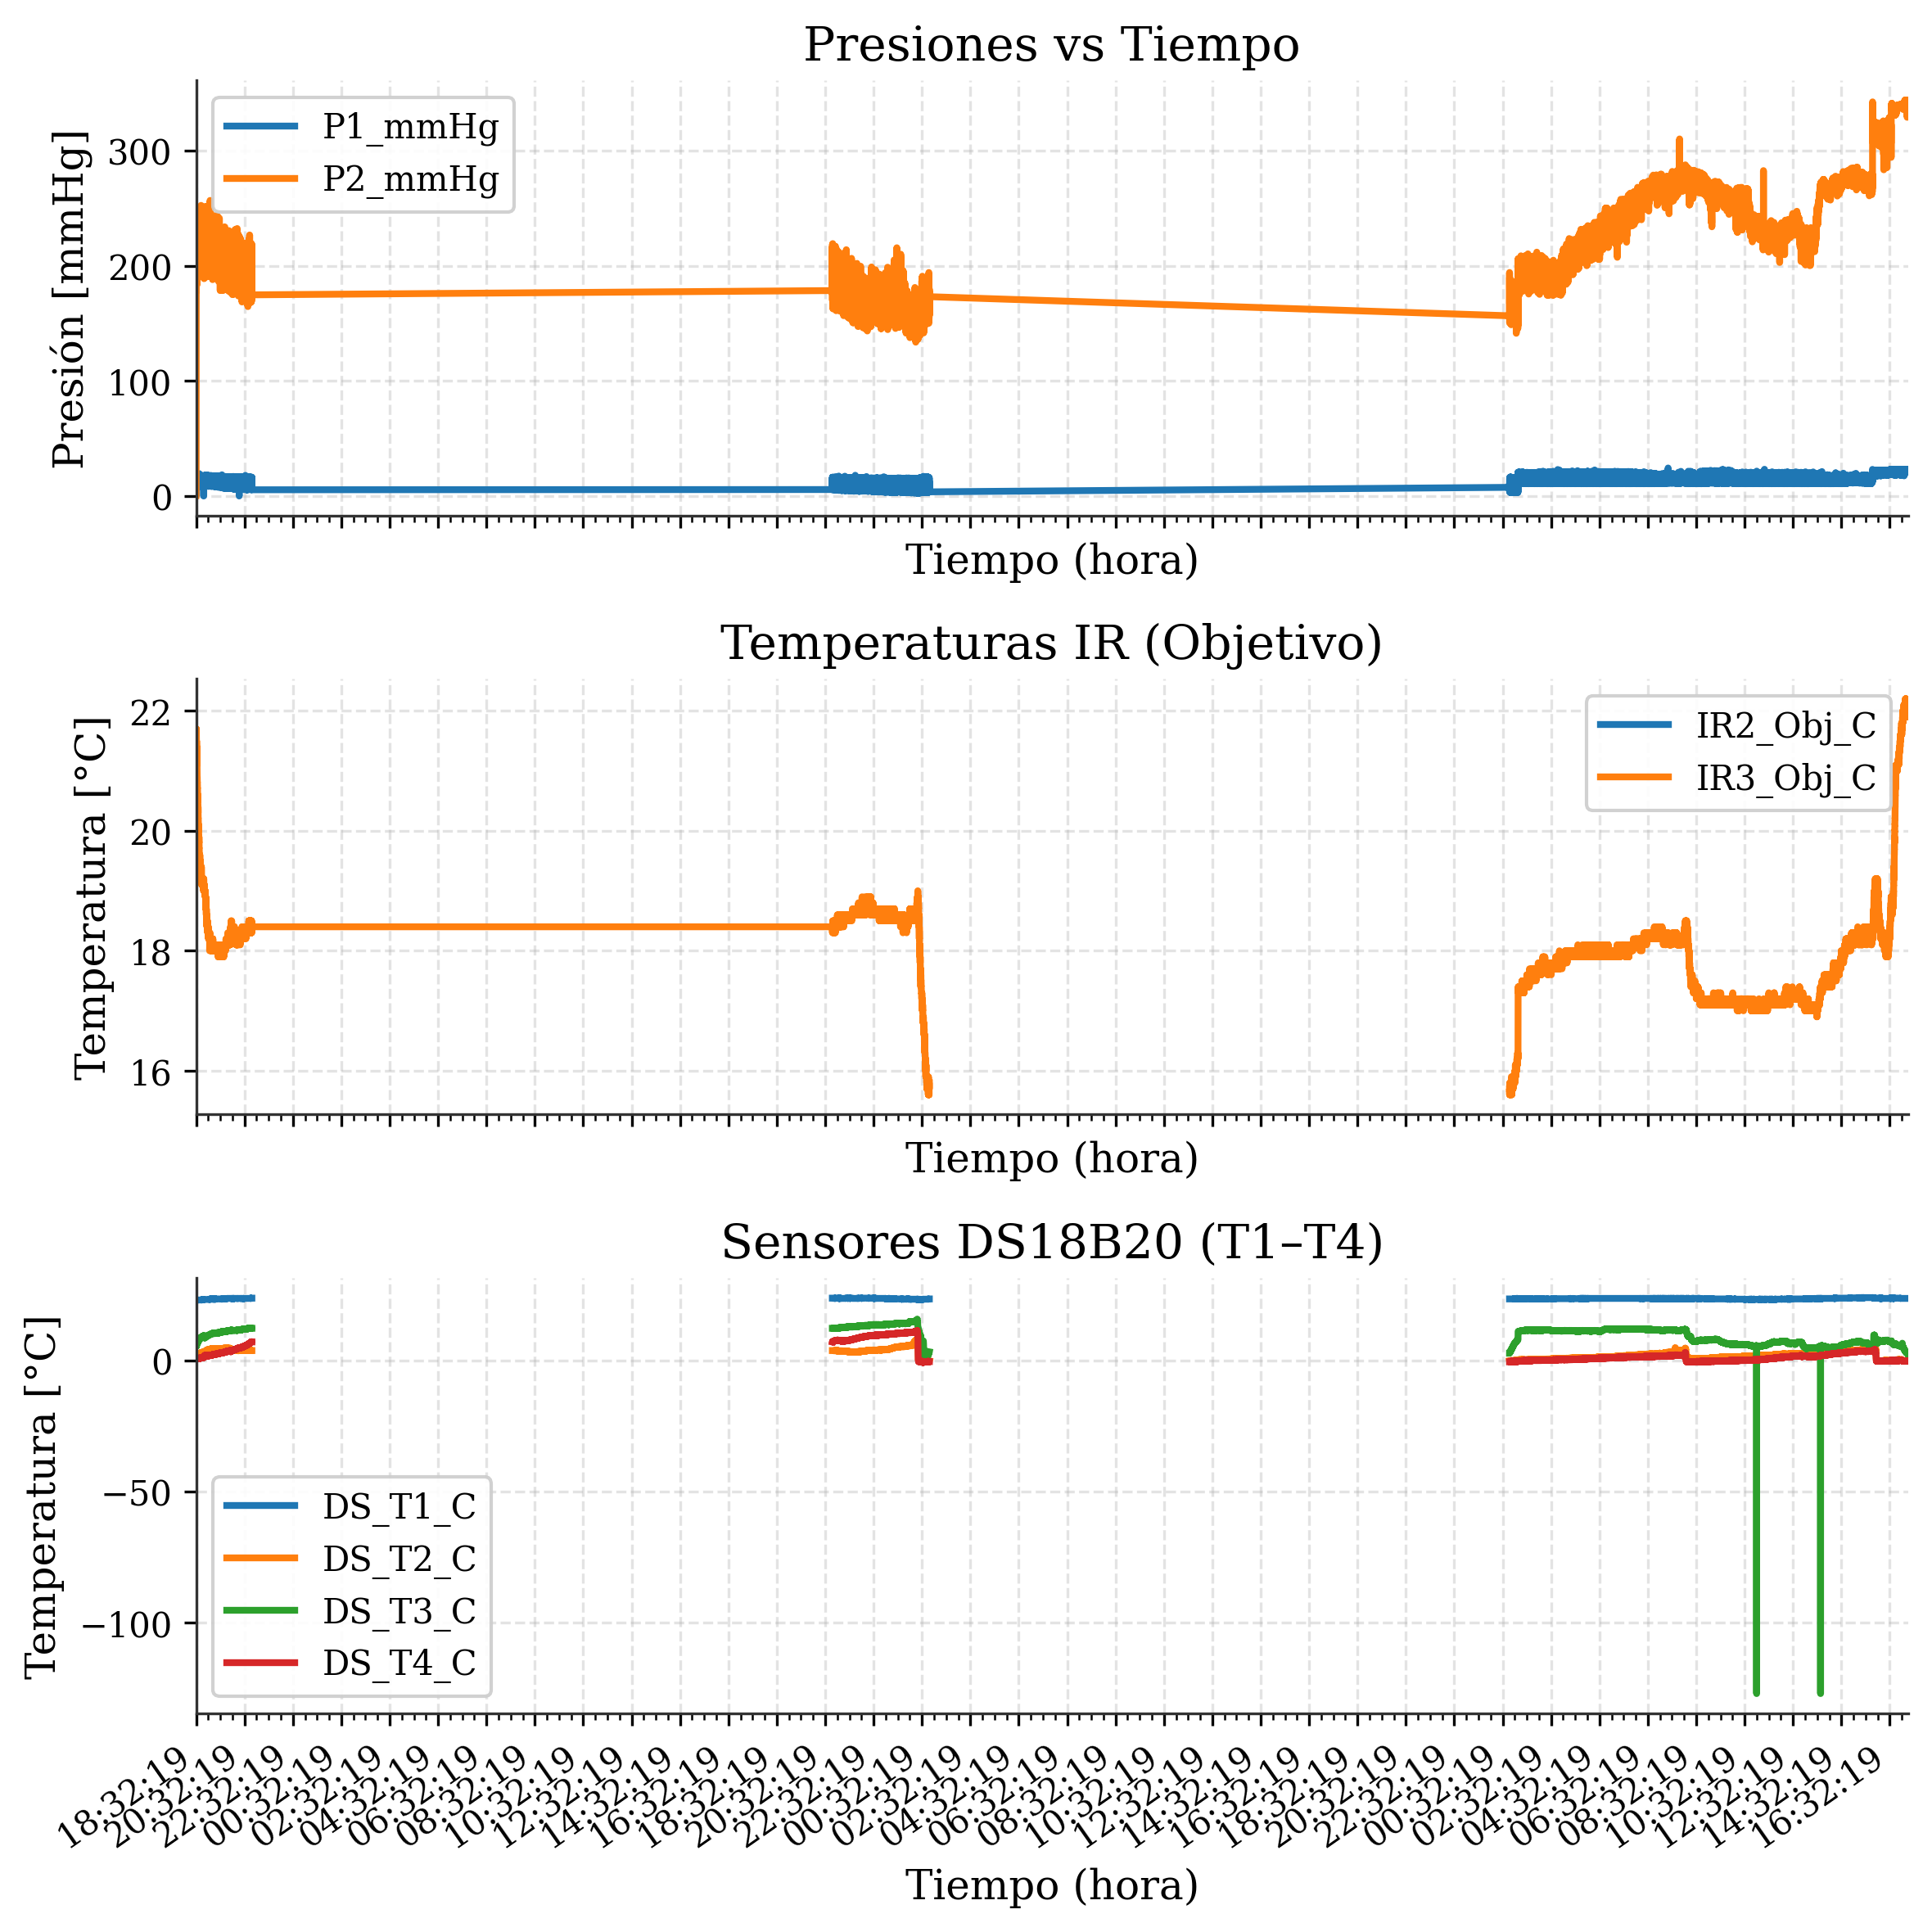

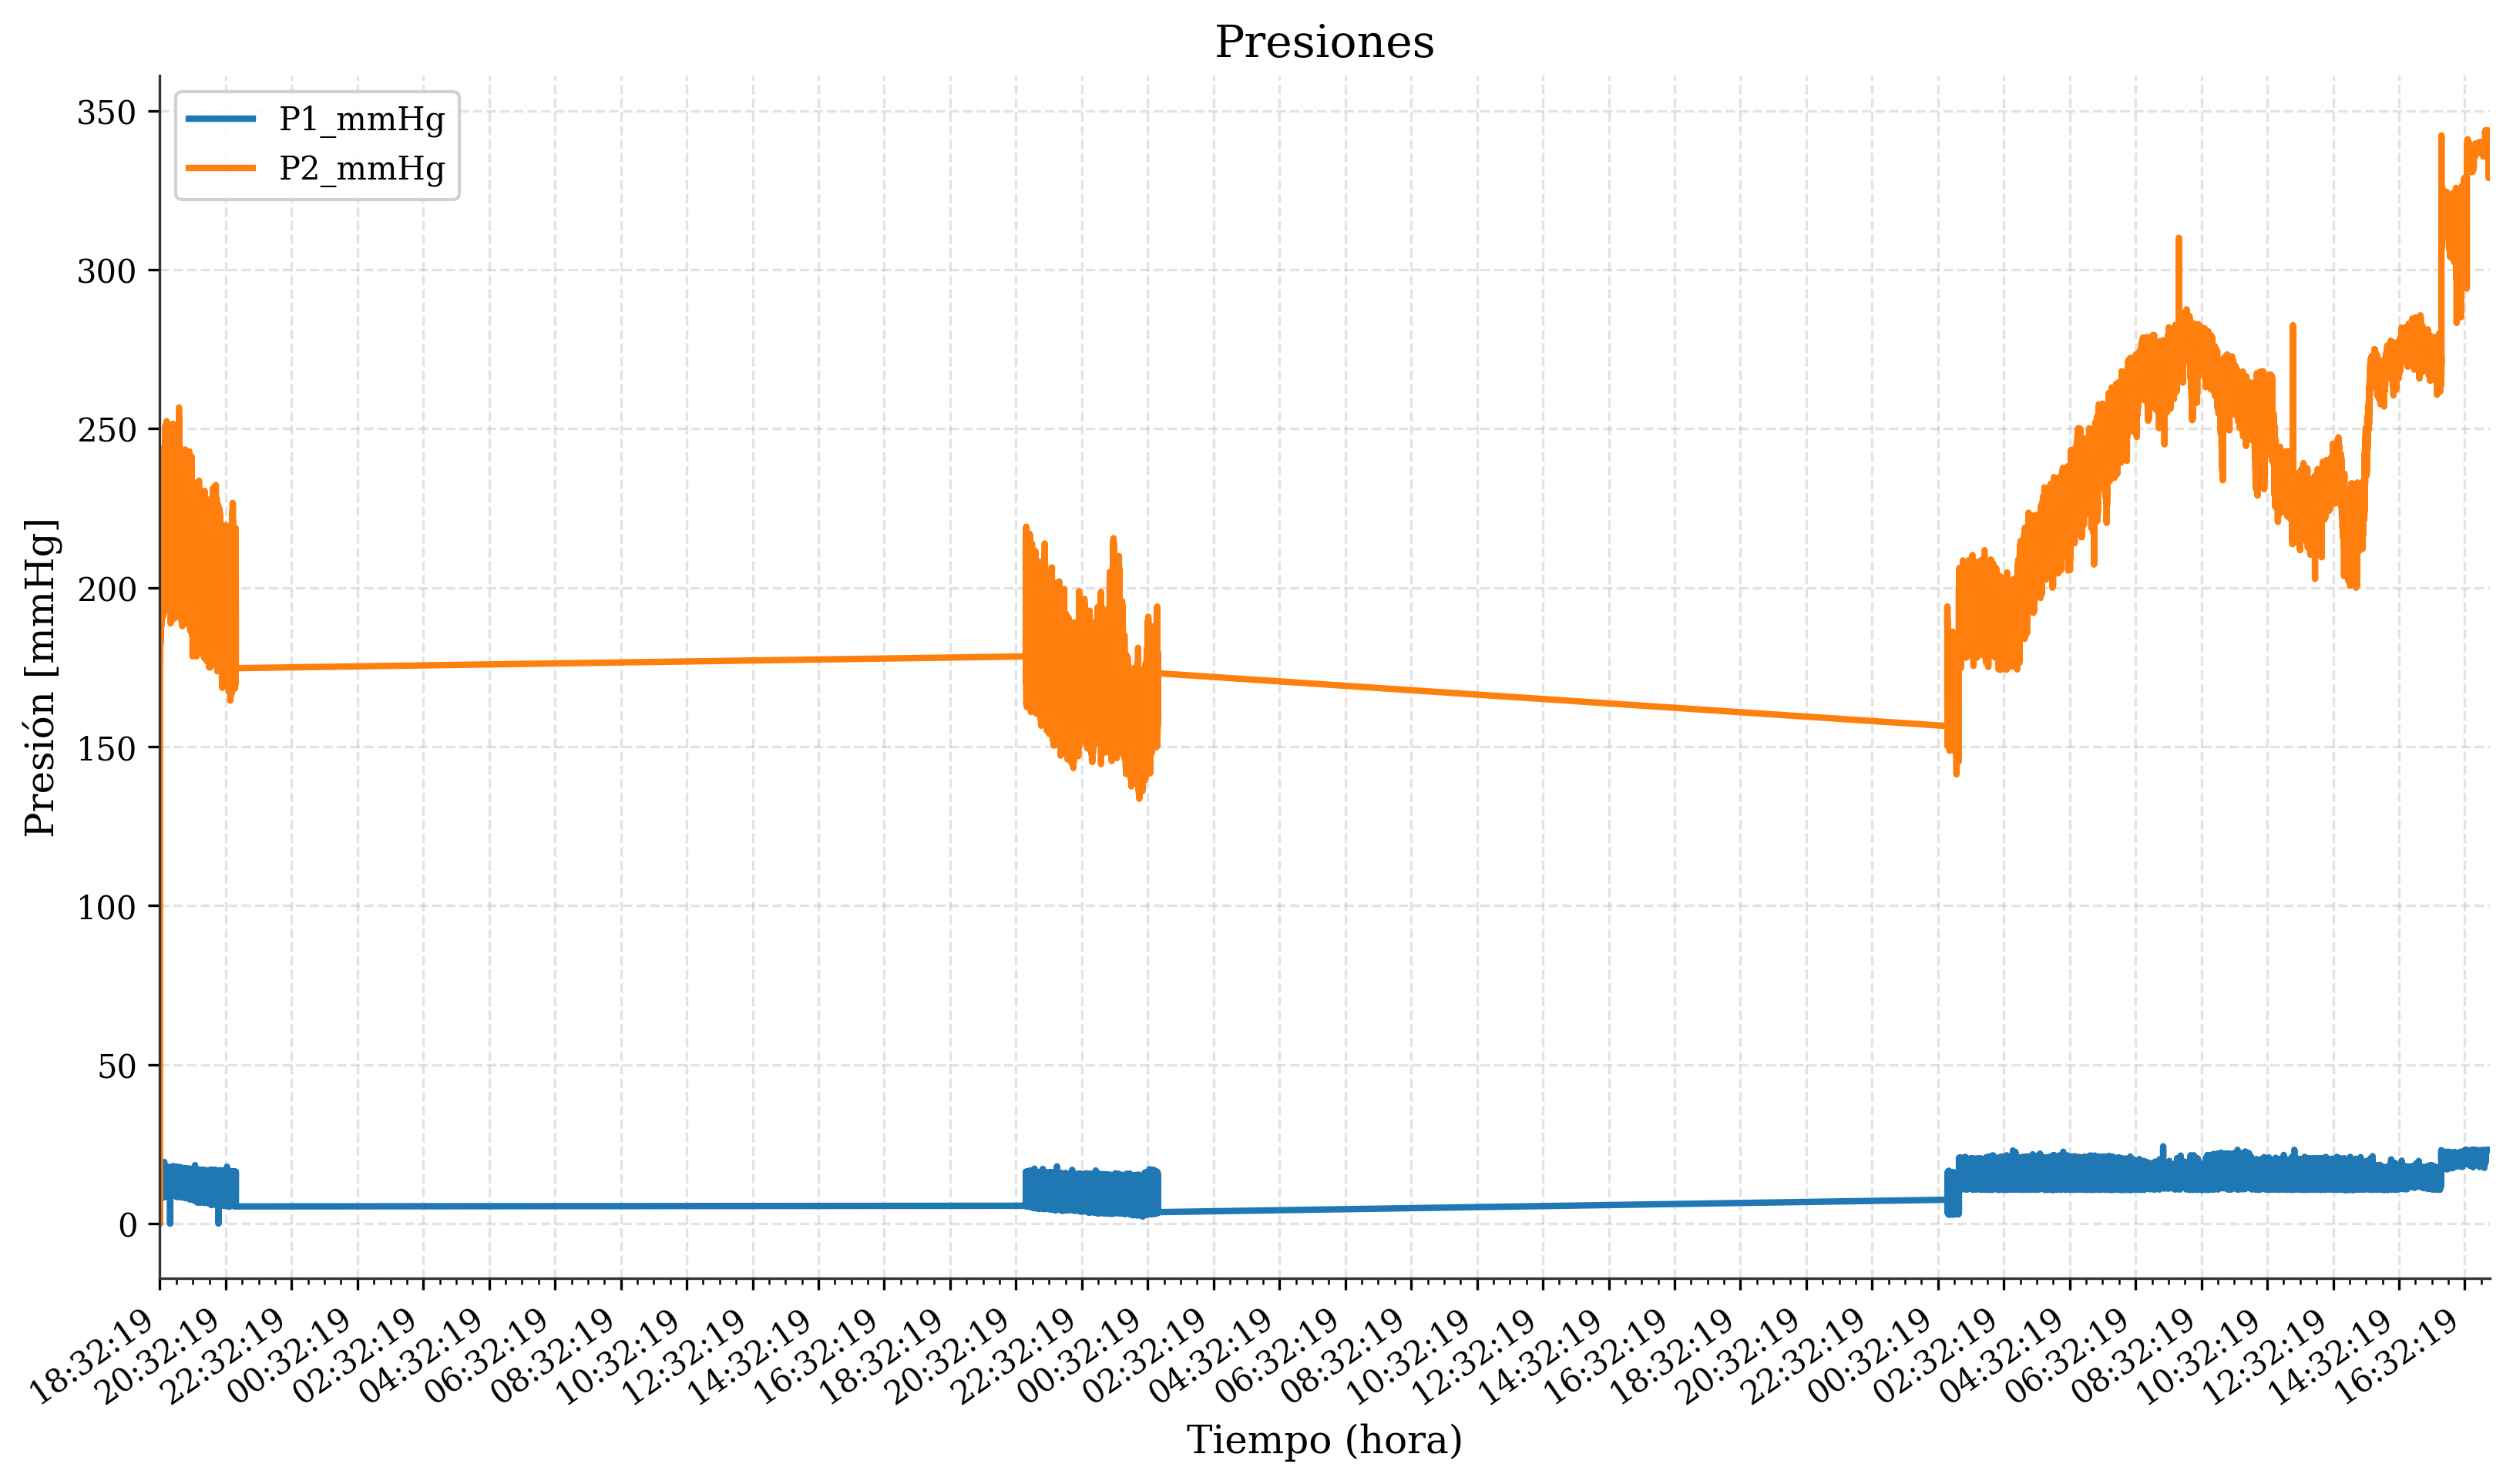

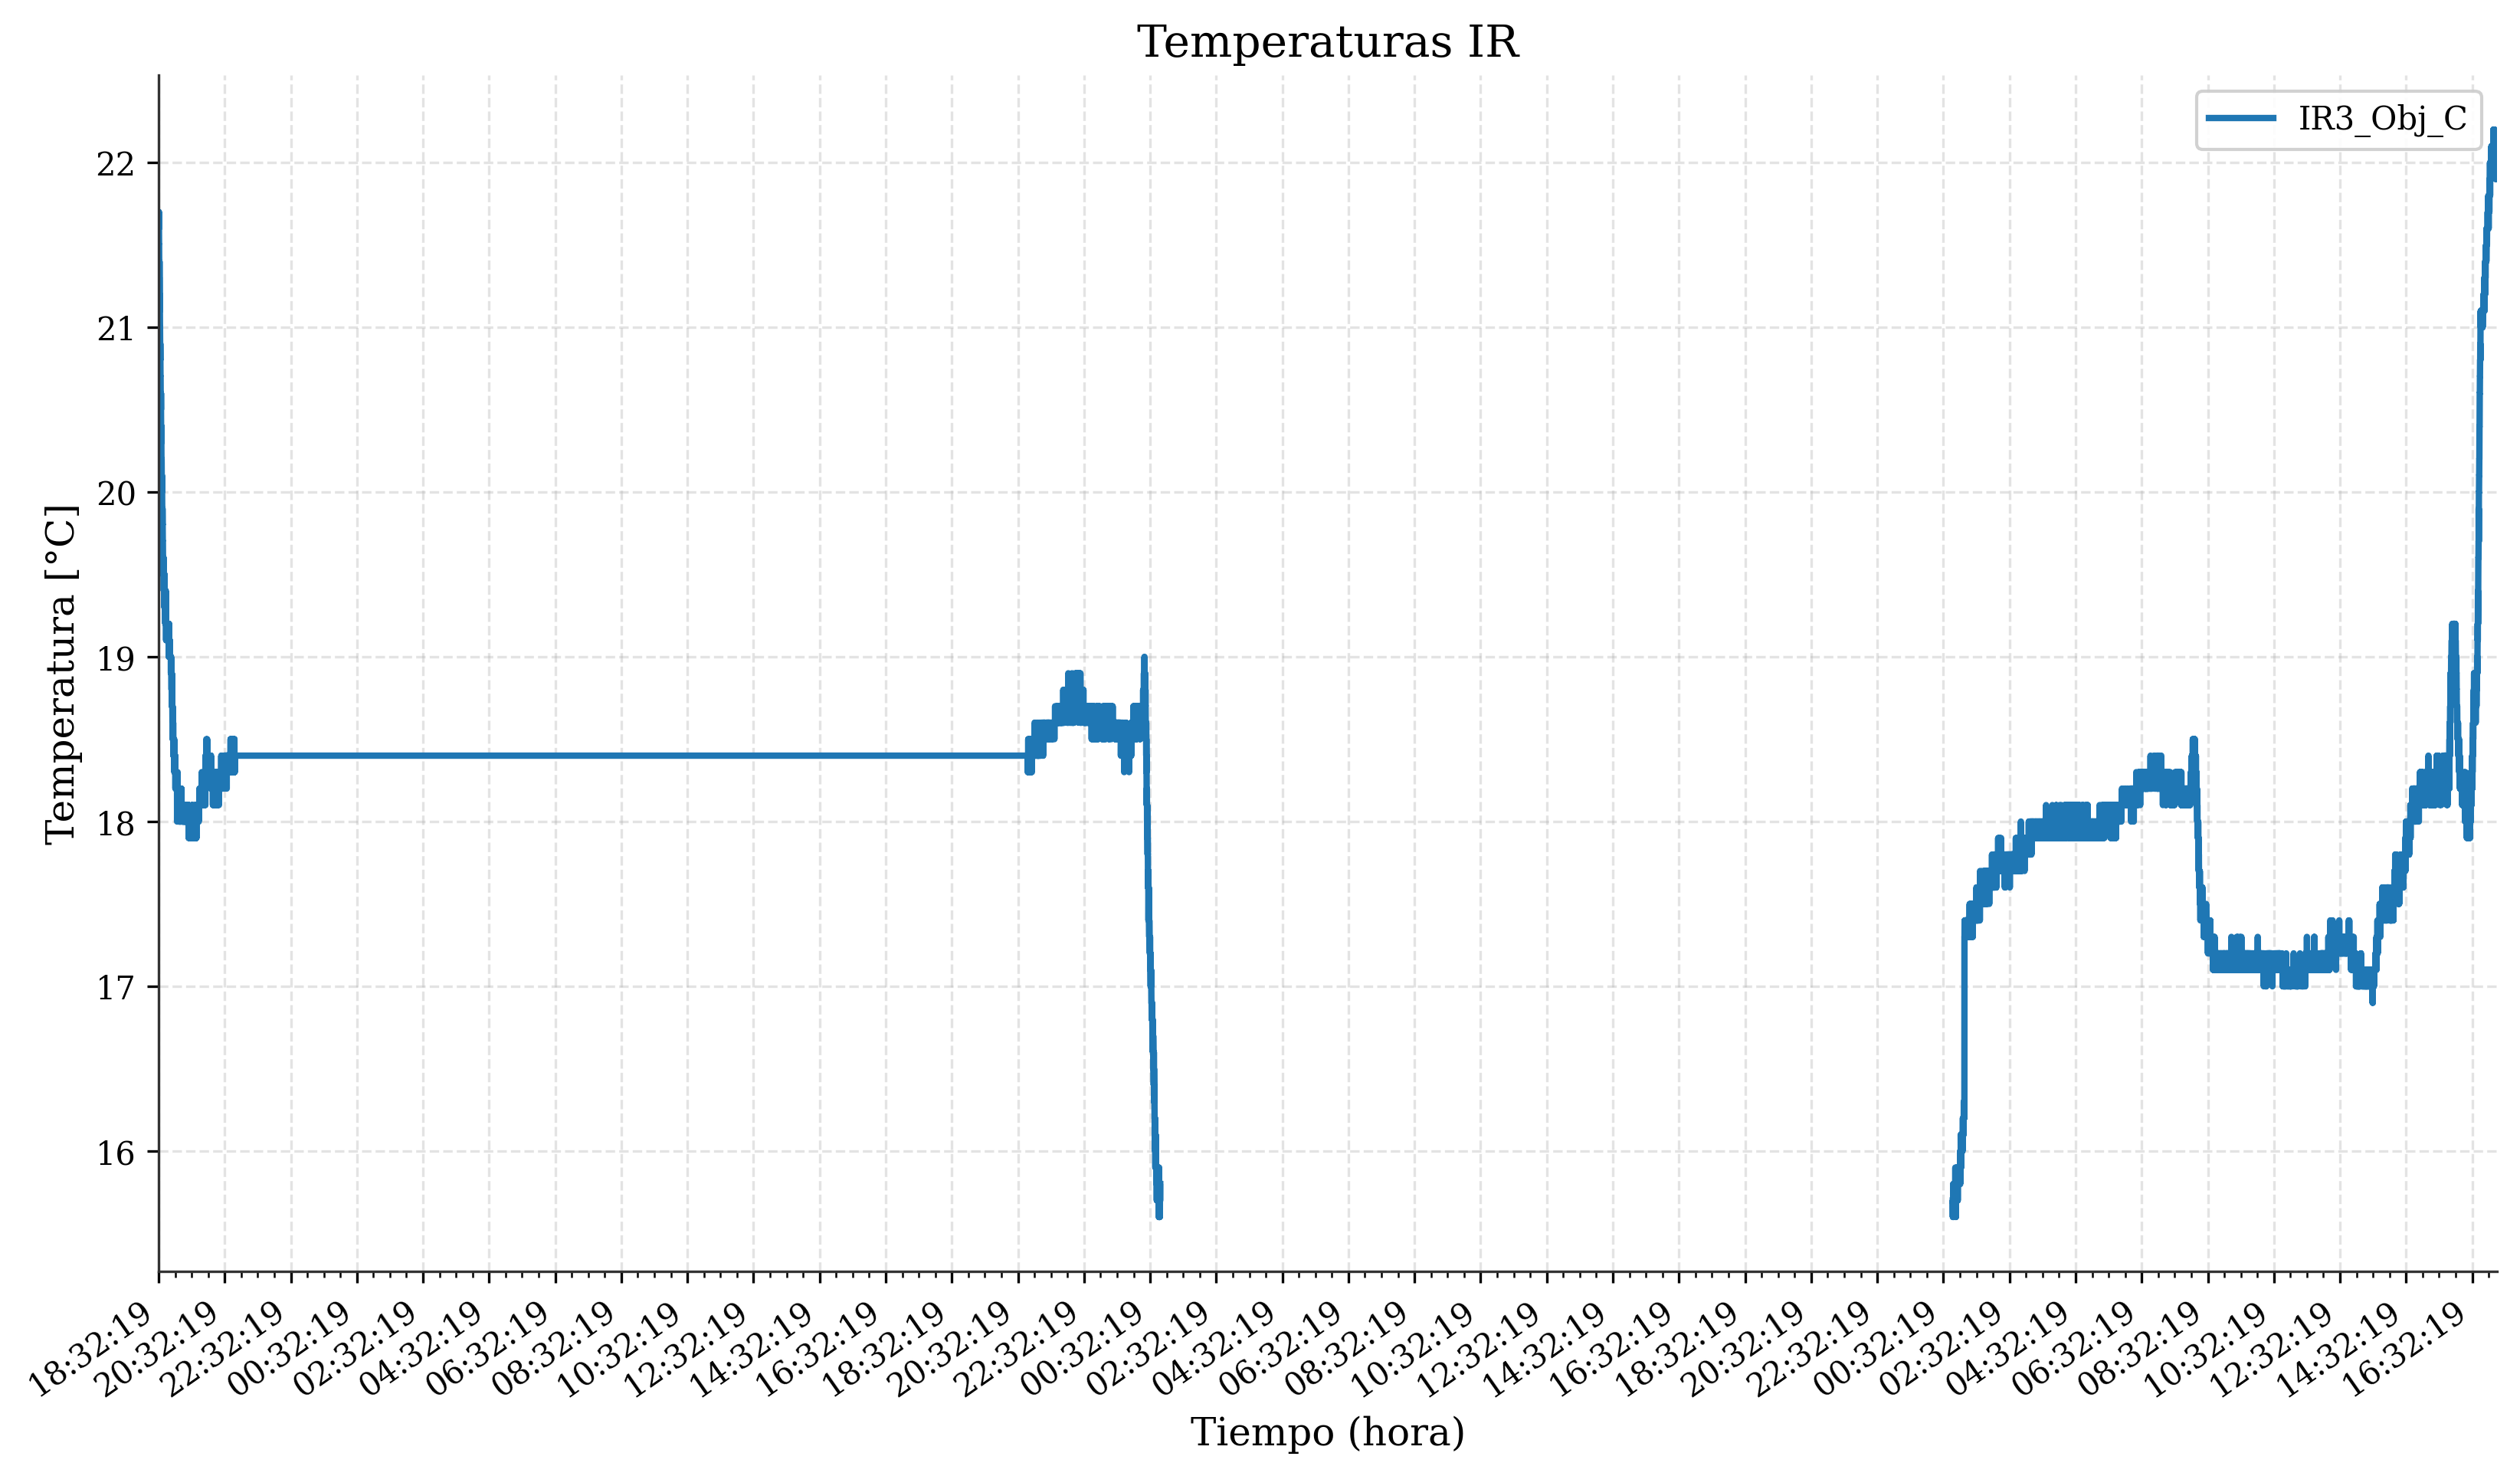

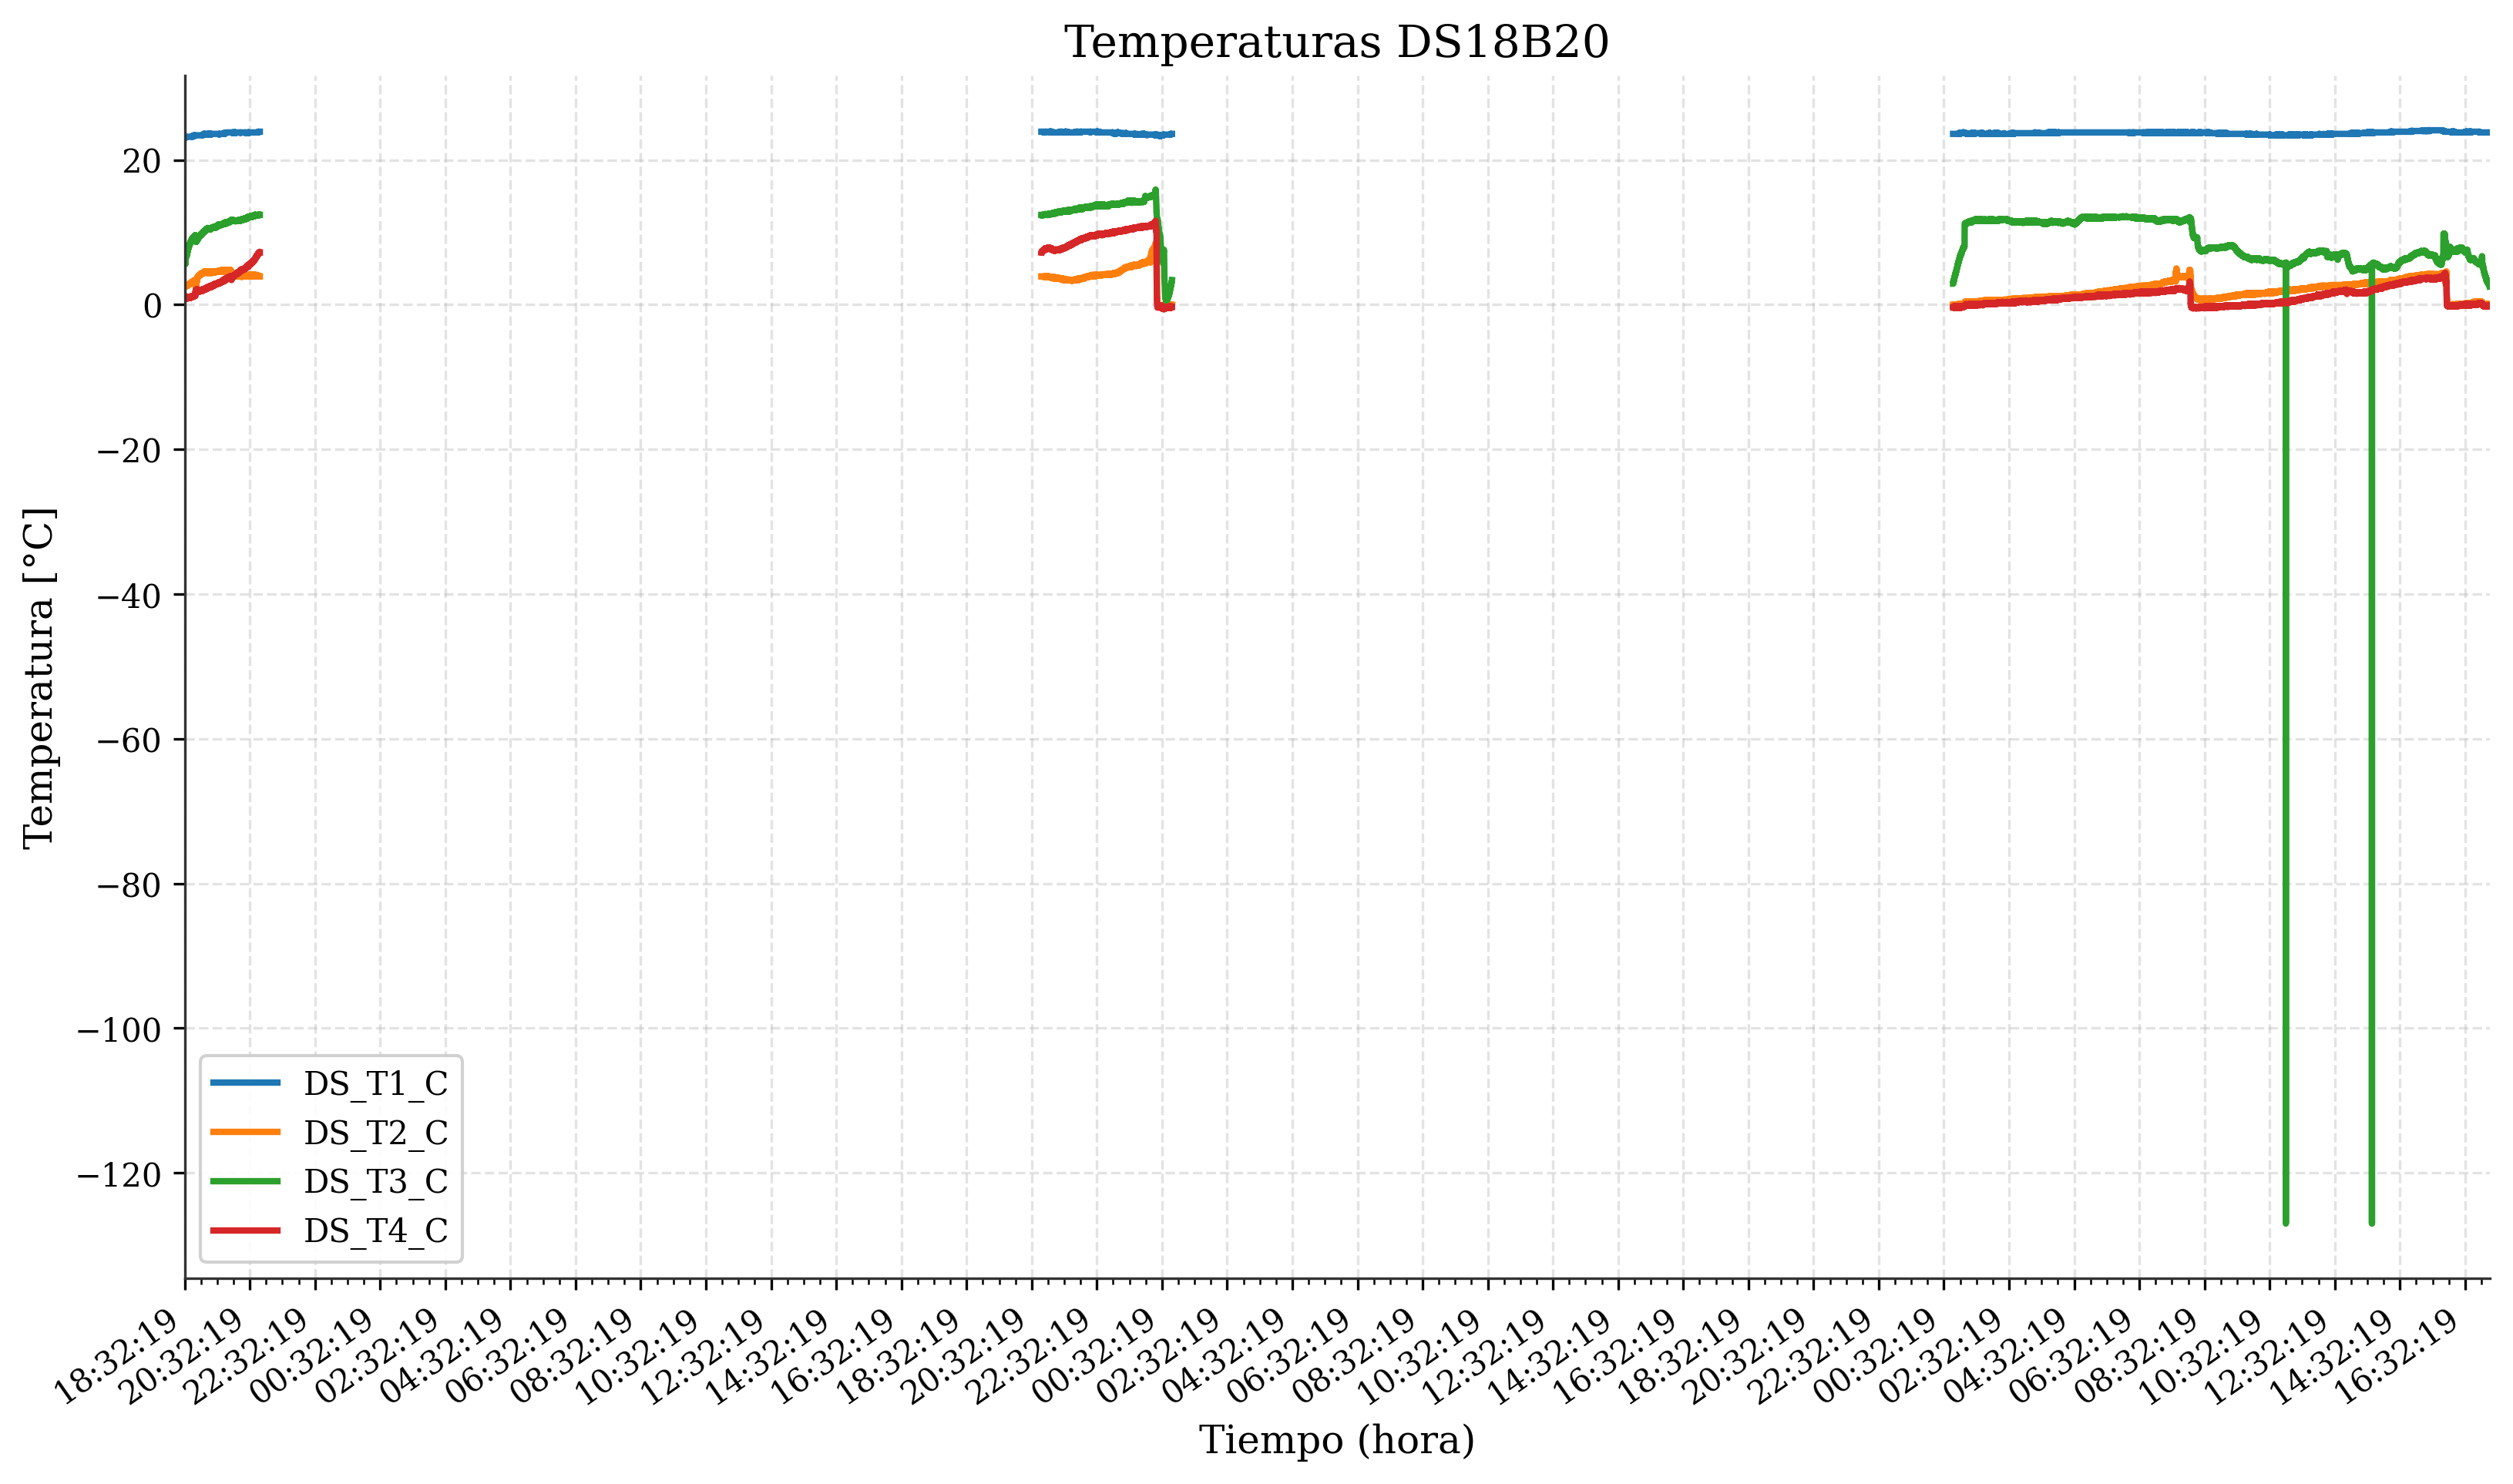

/tmp/ipython-input-3105832059.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start = pd.to_datetime(x_dt.iloc[0]).round('S')


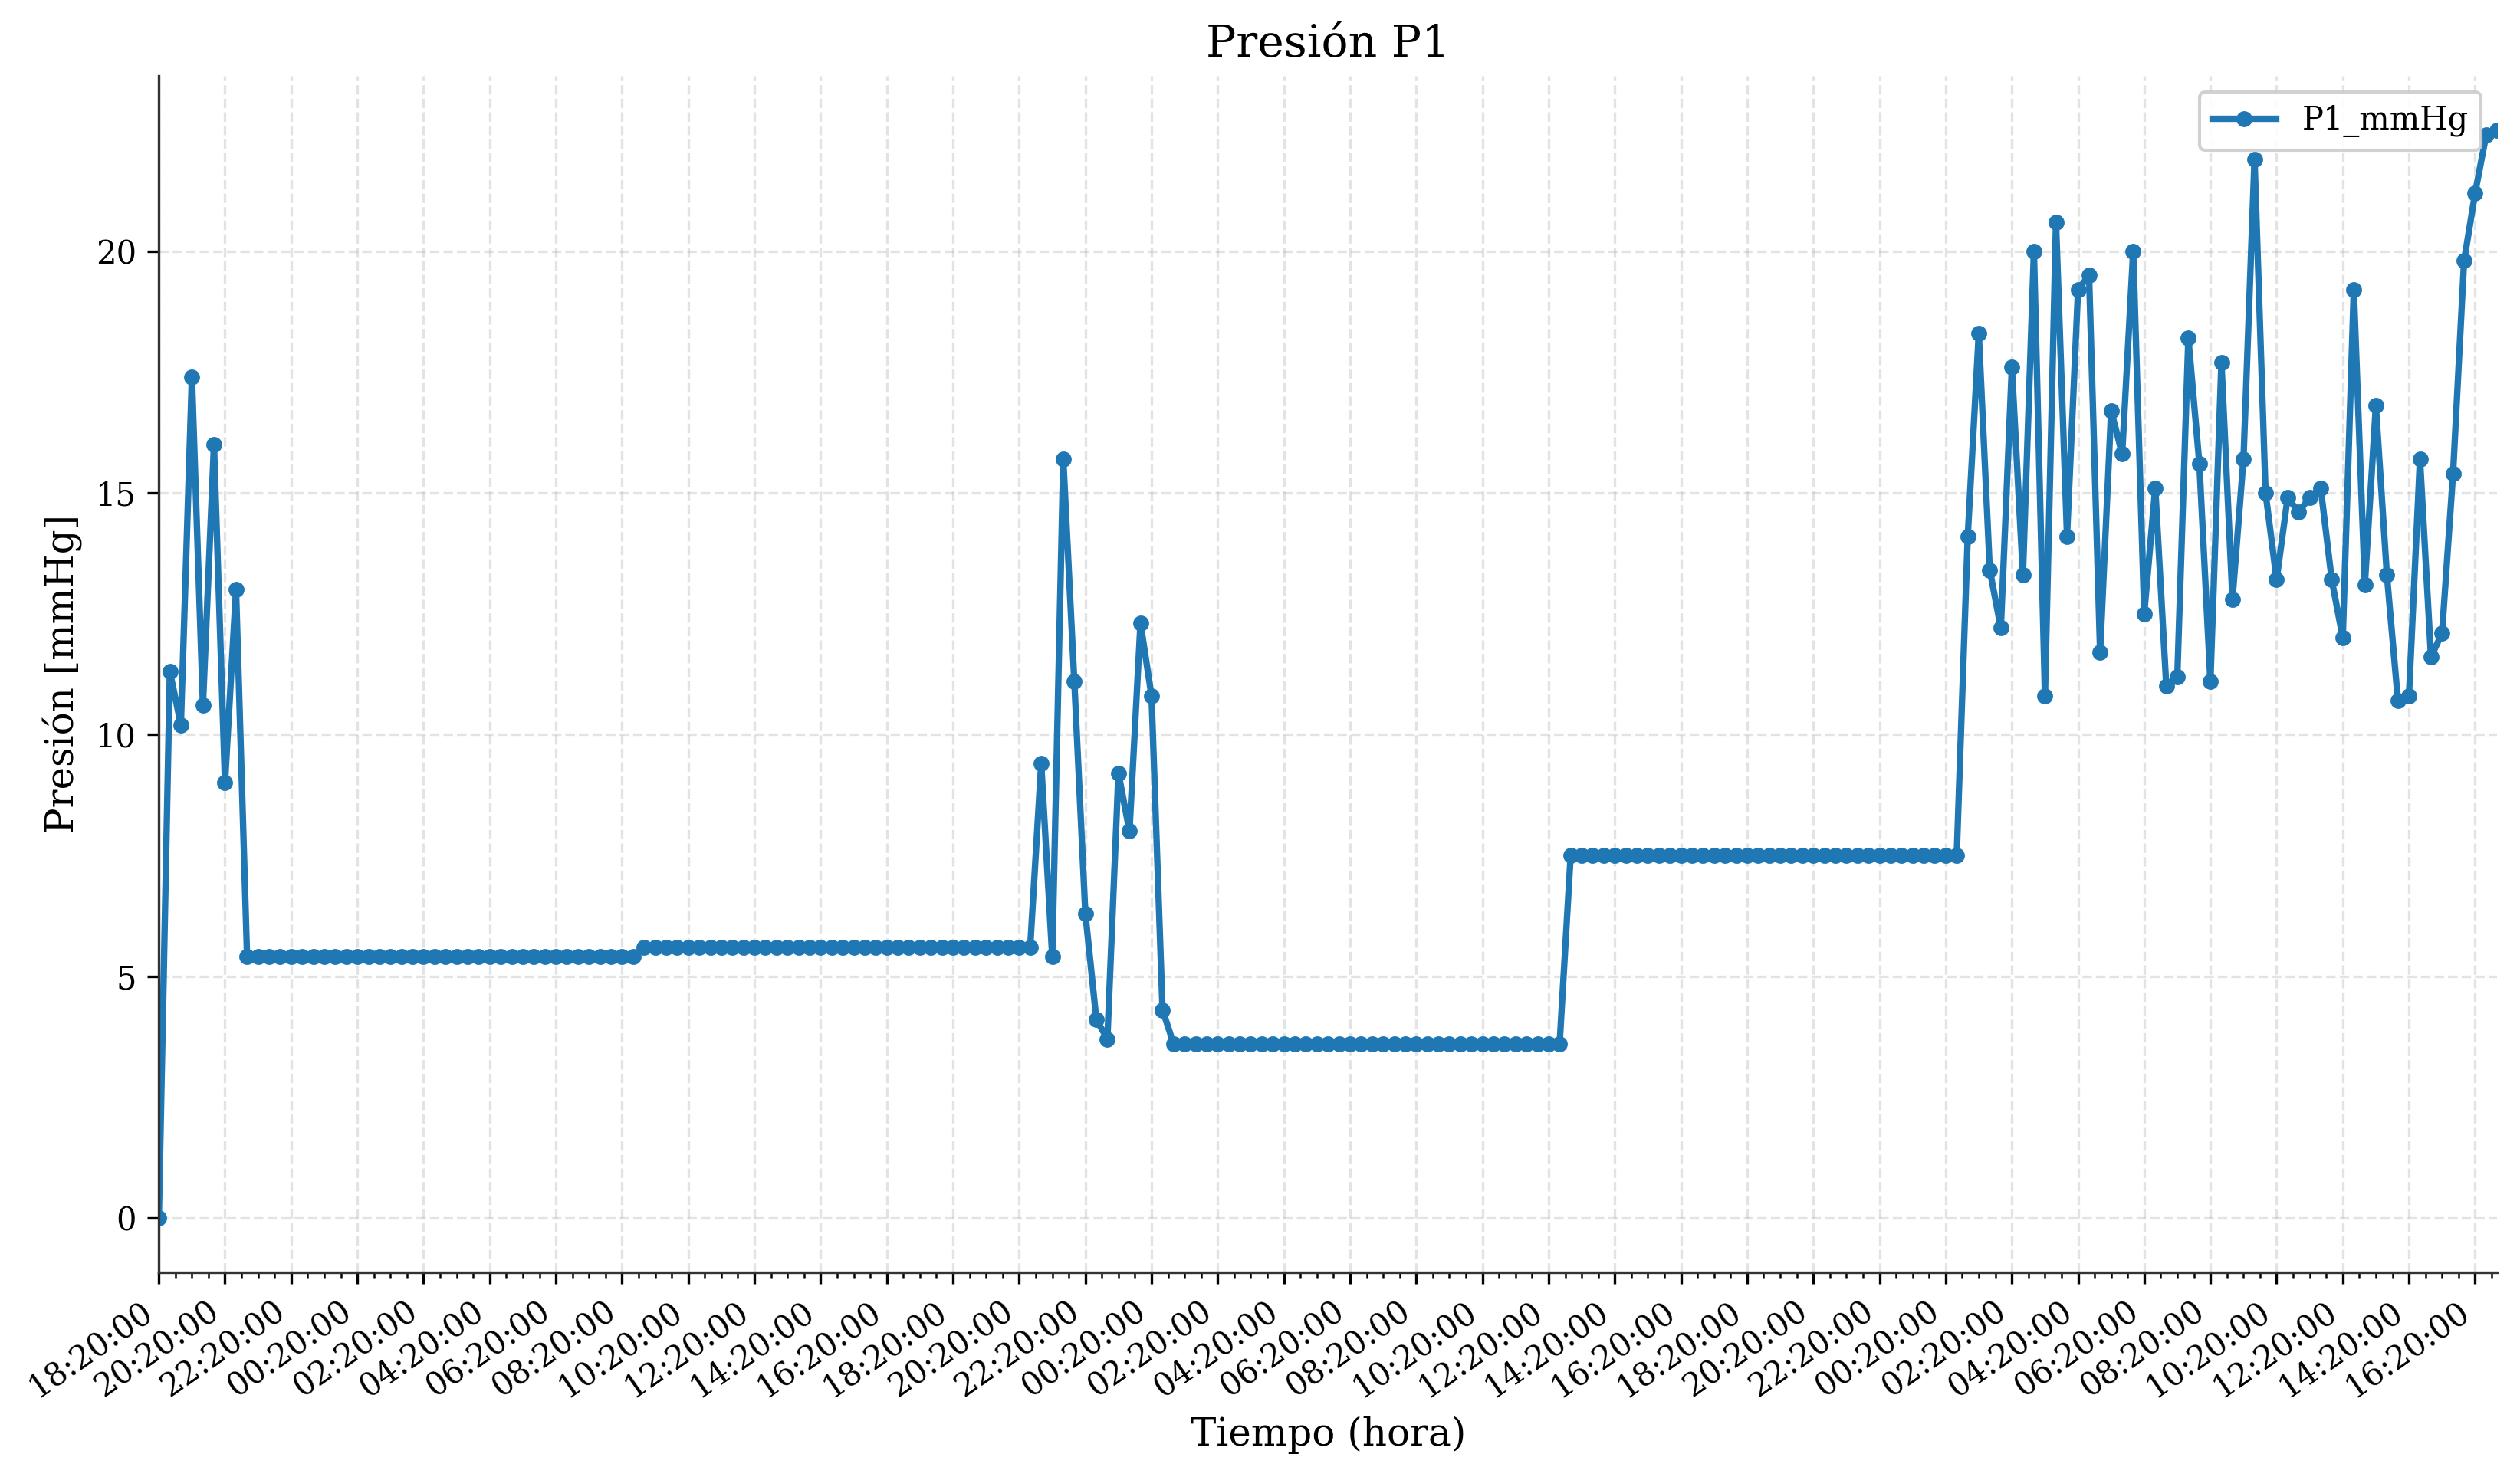

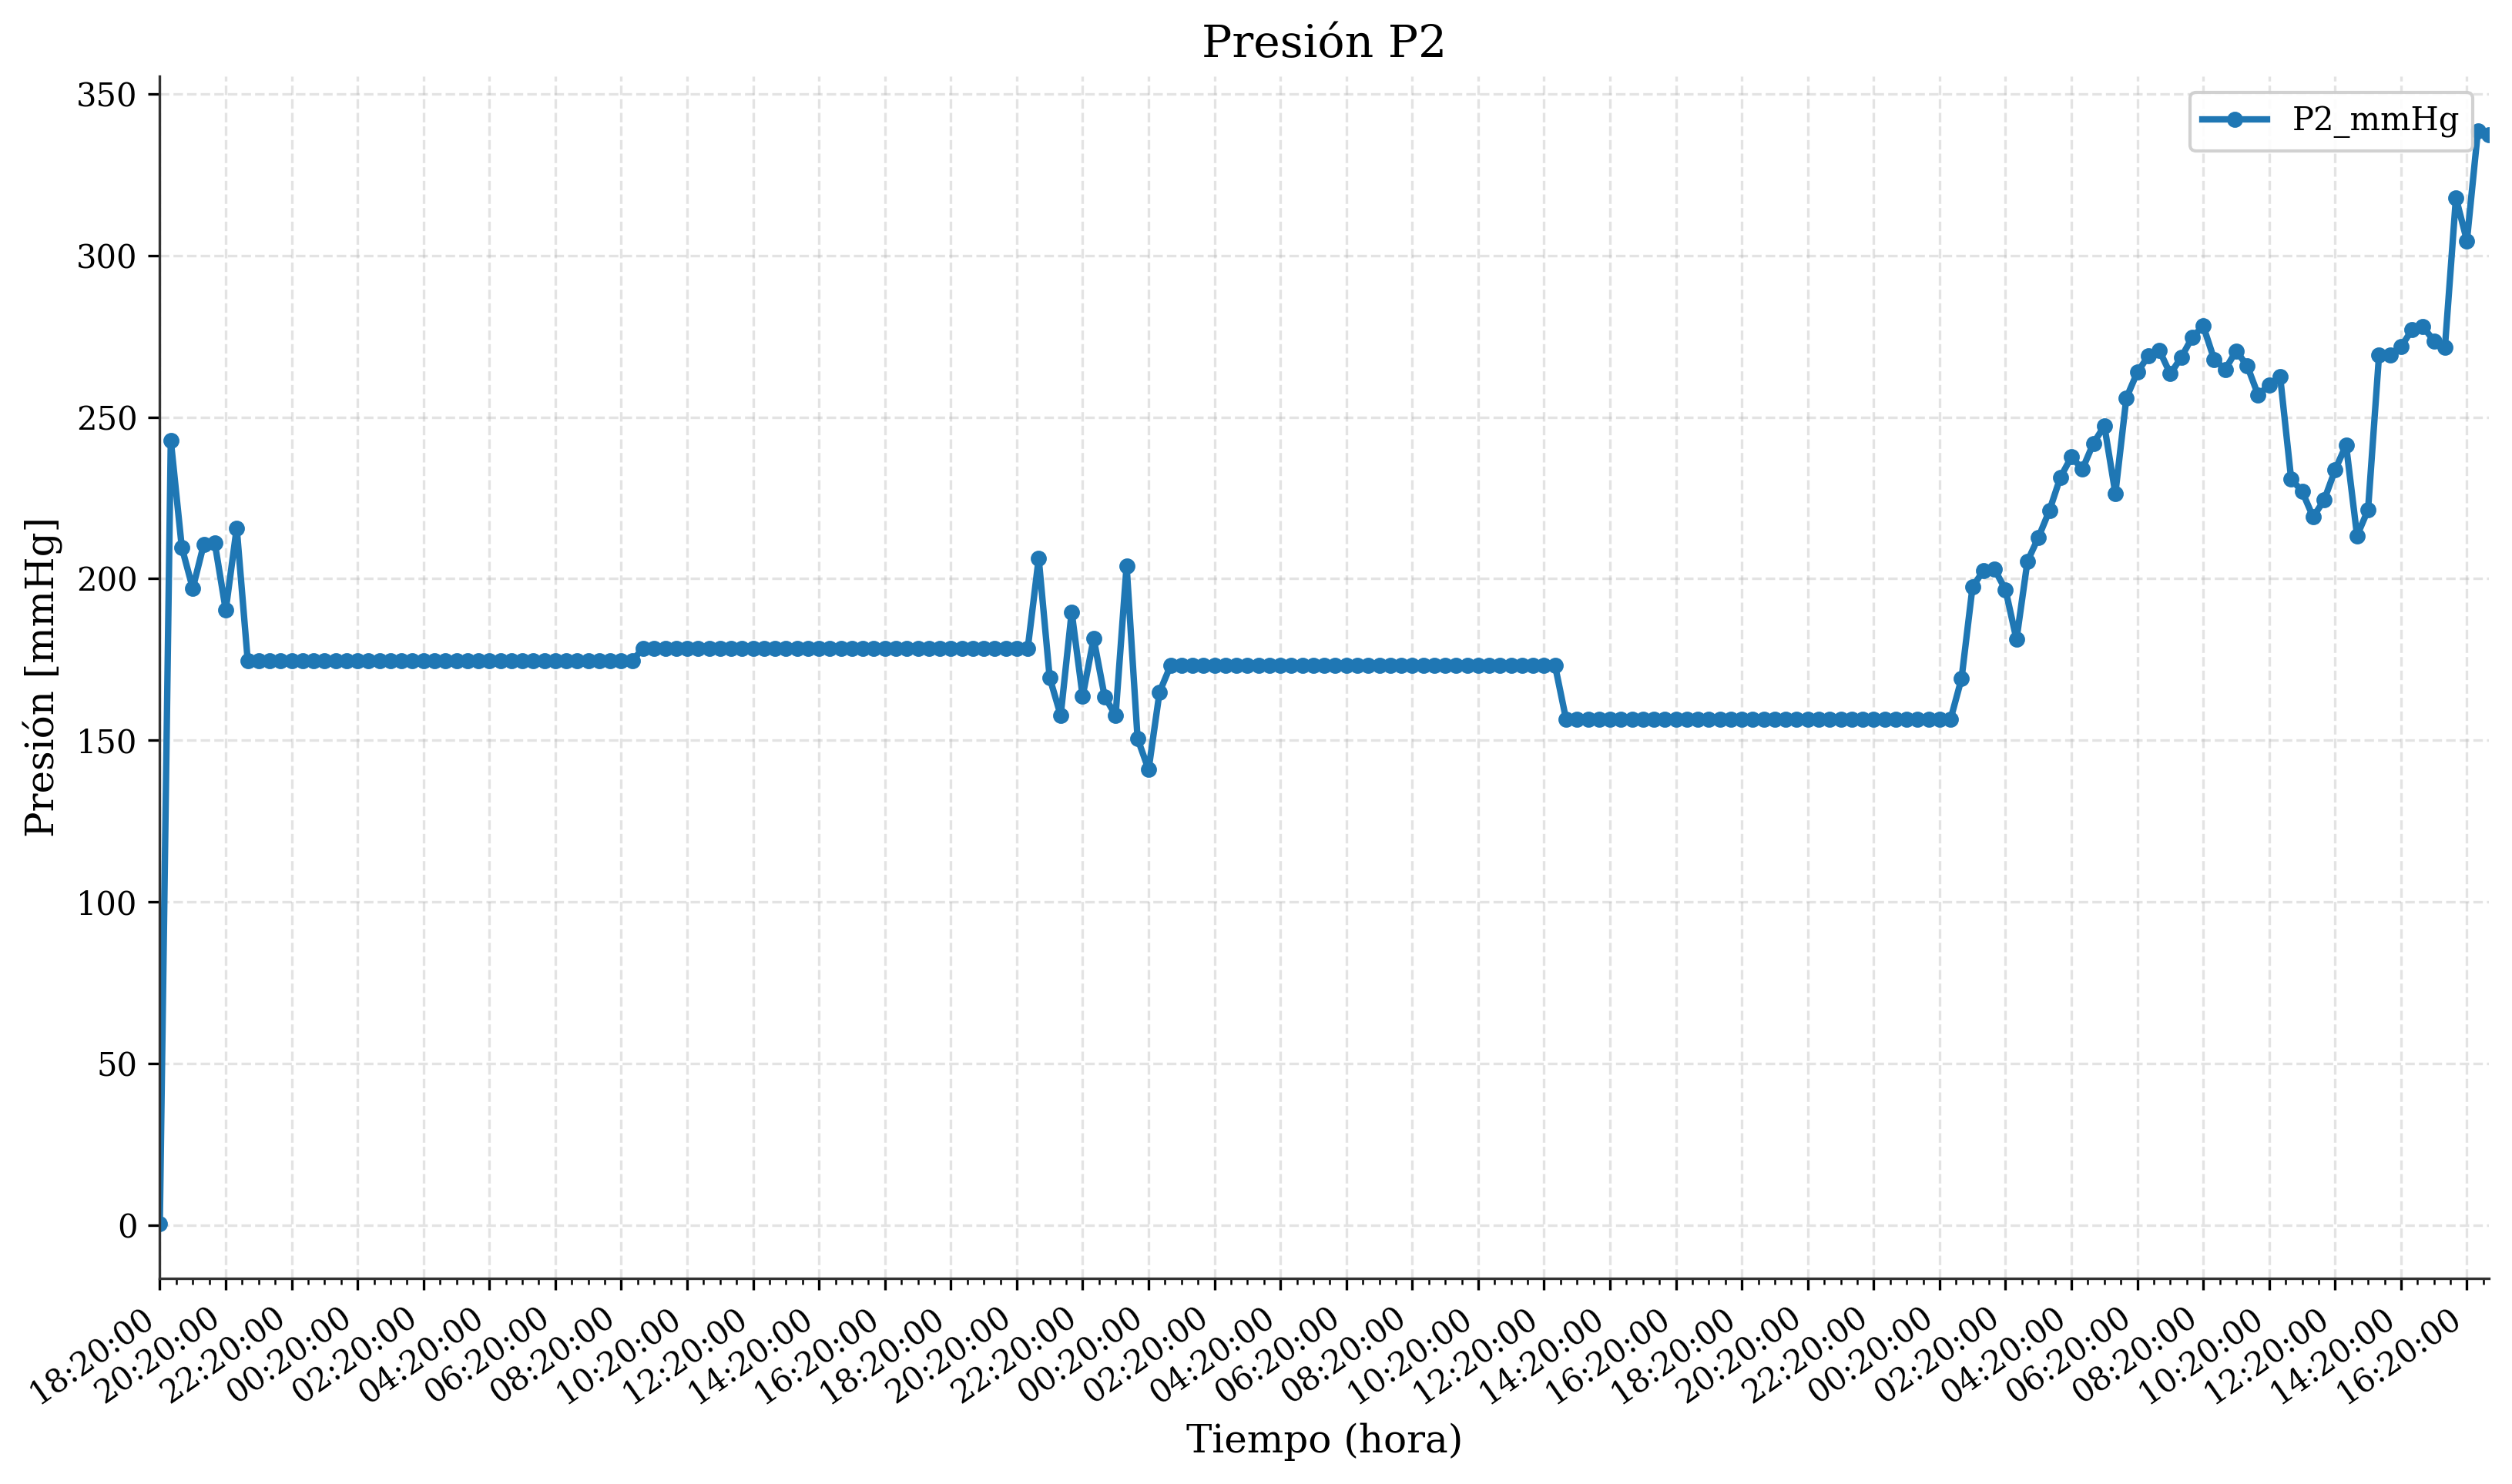

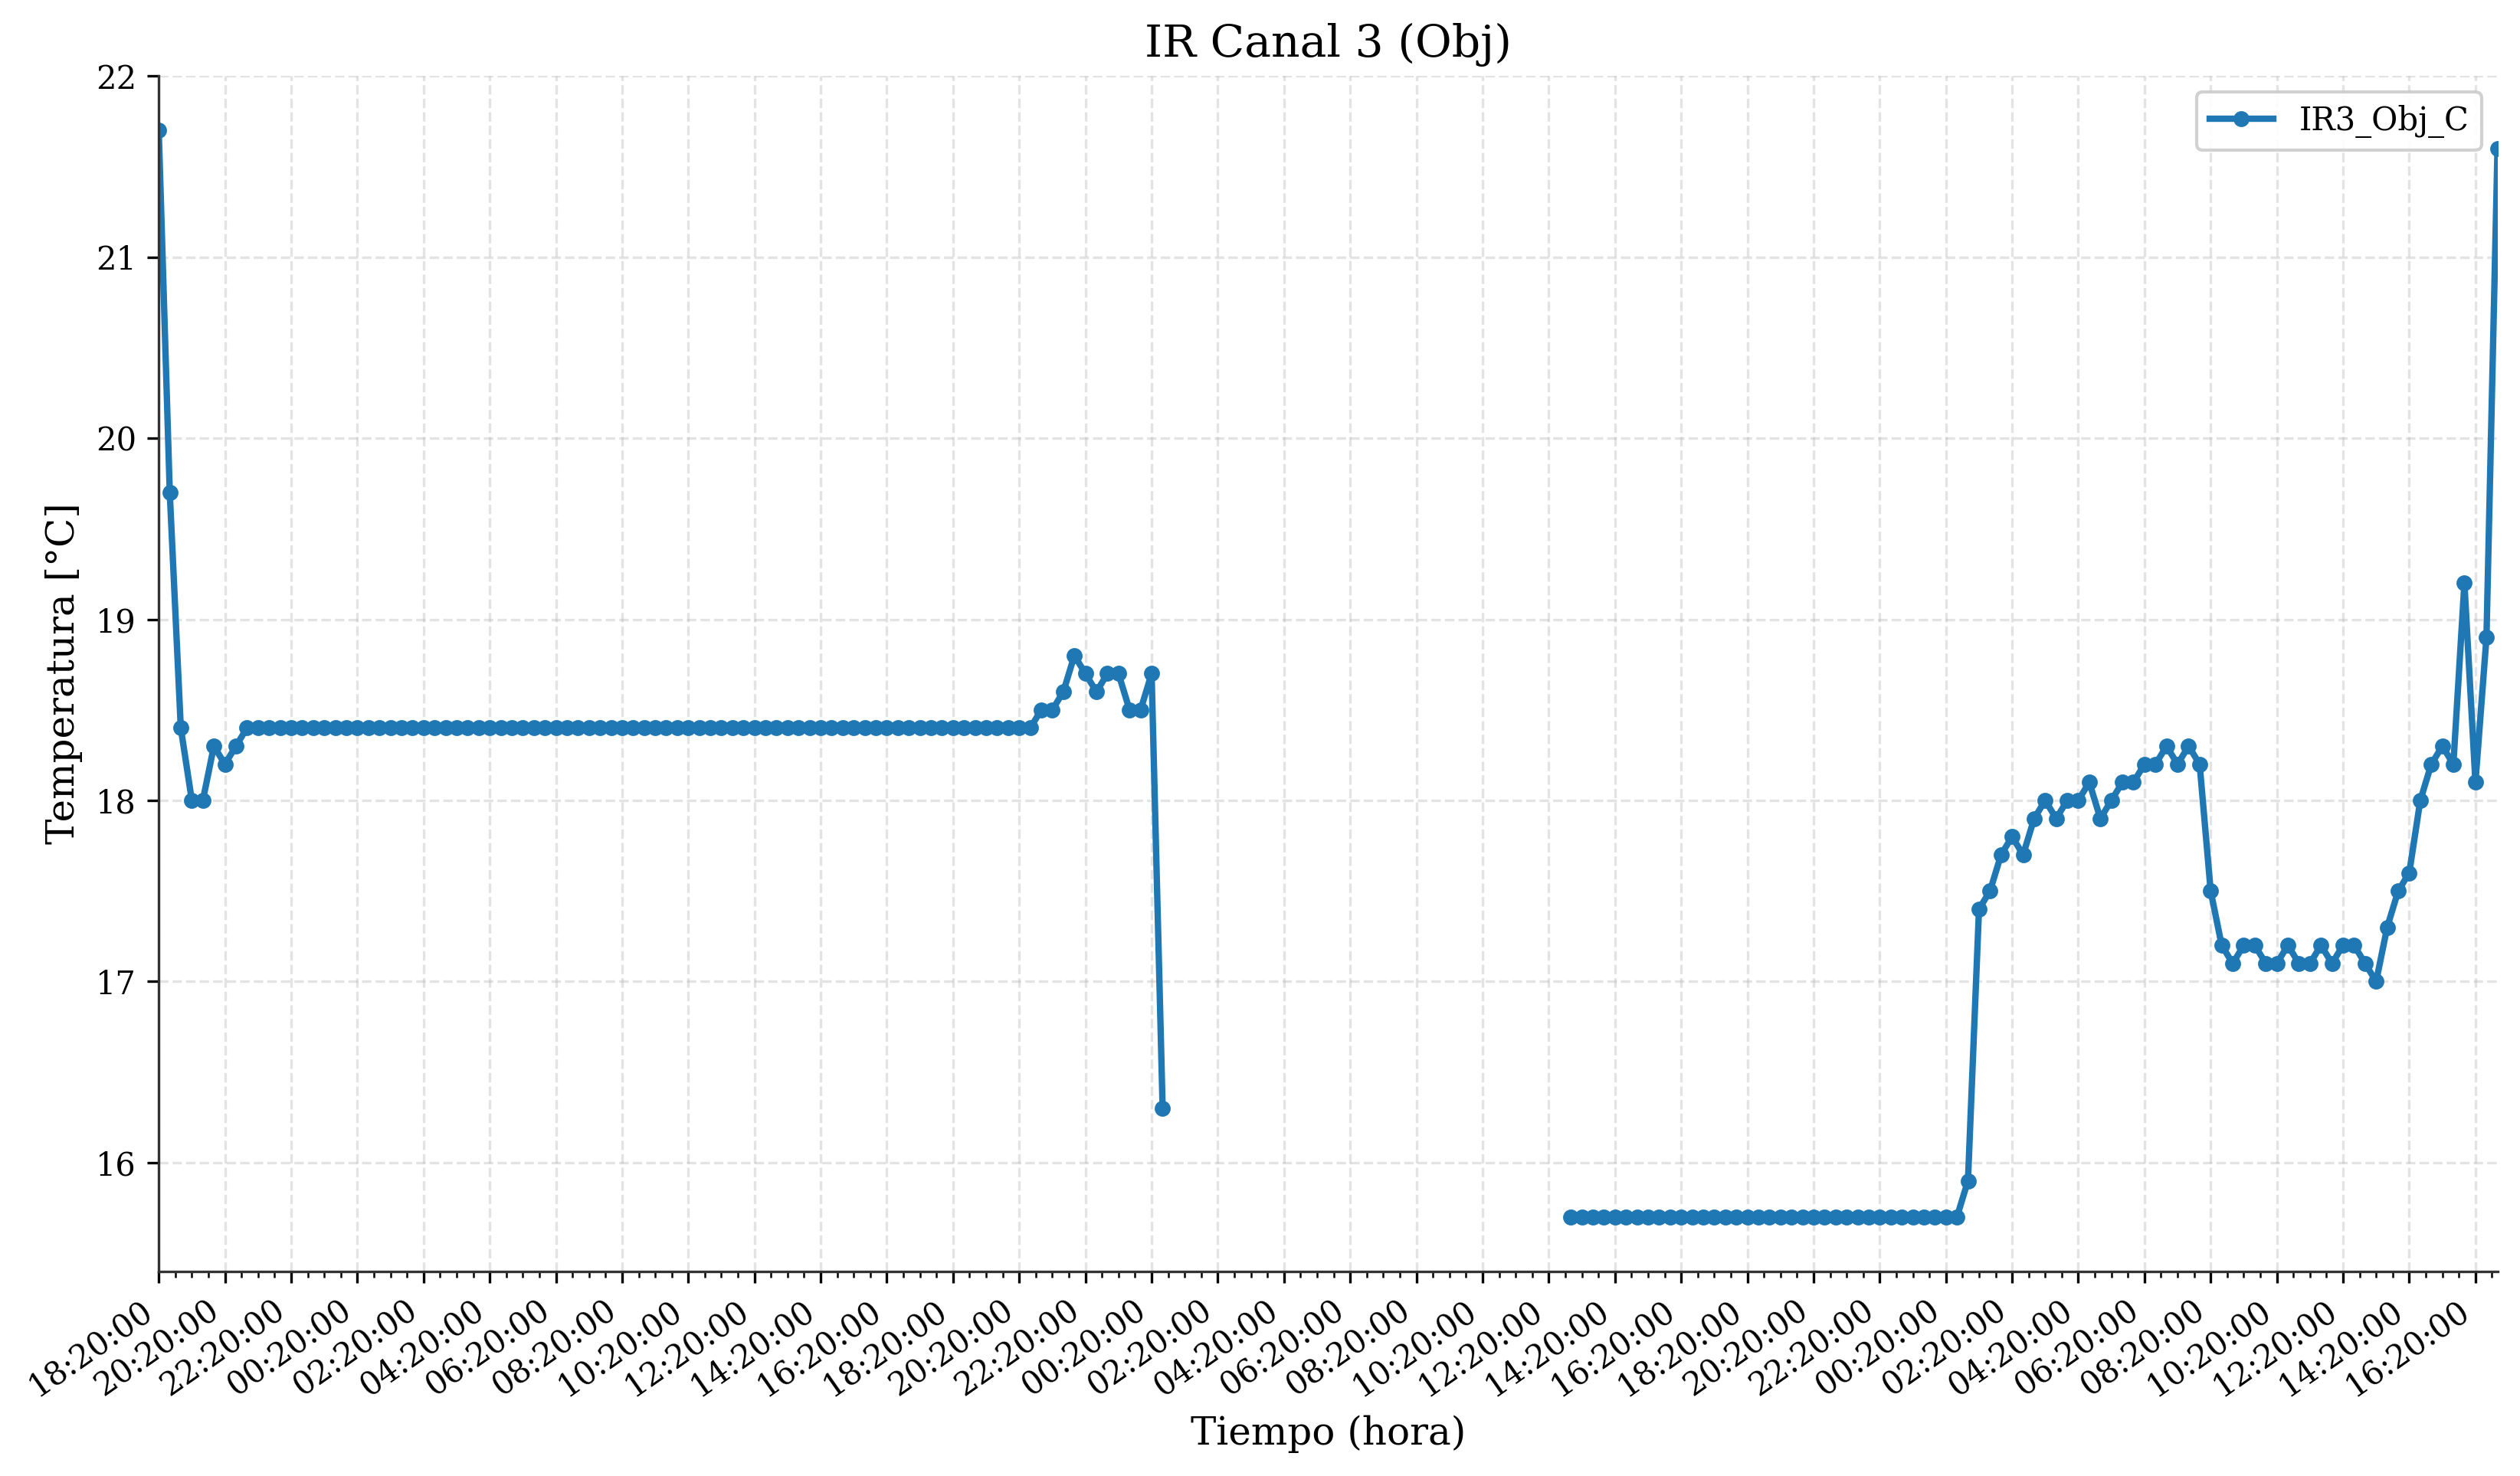

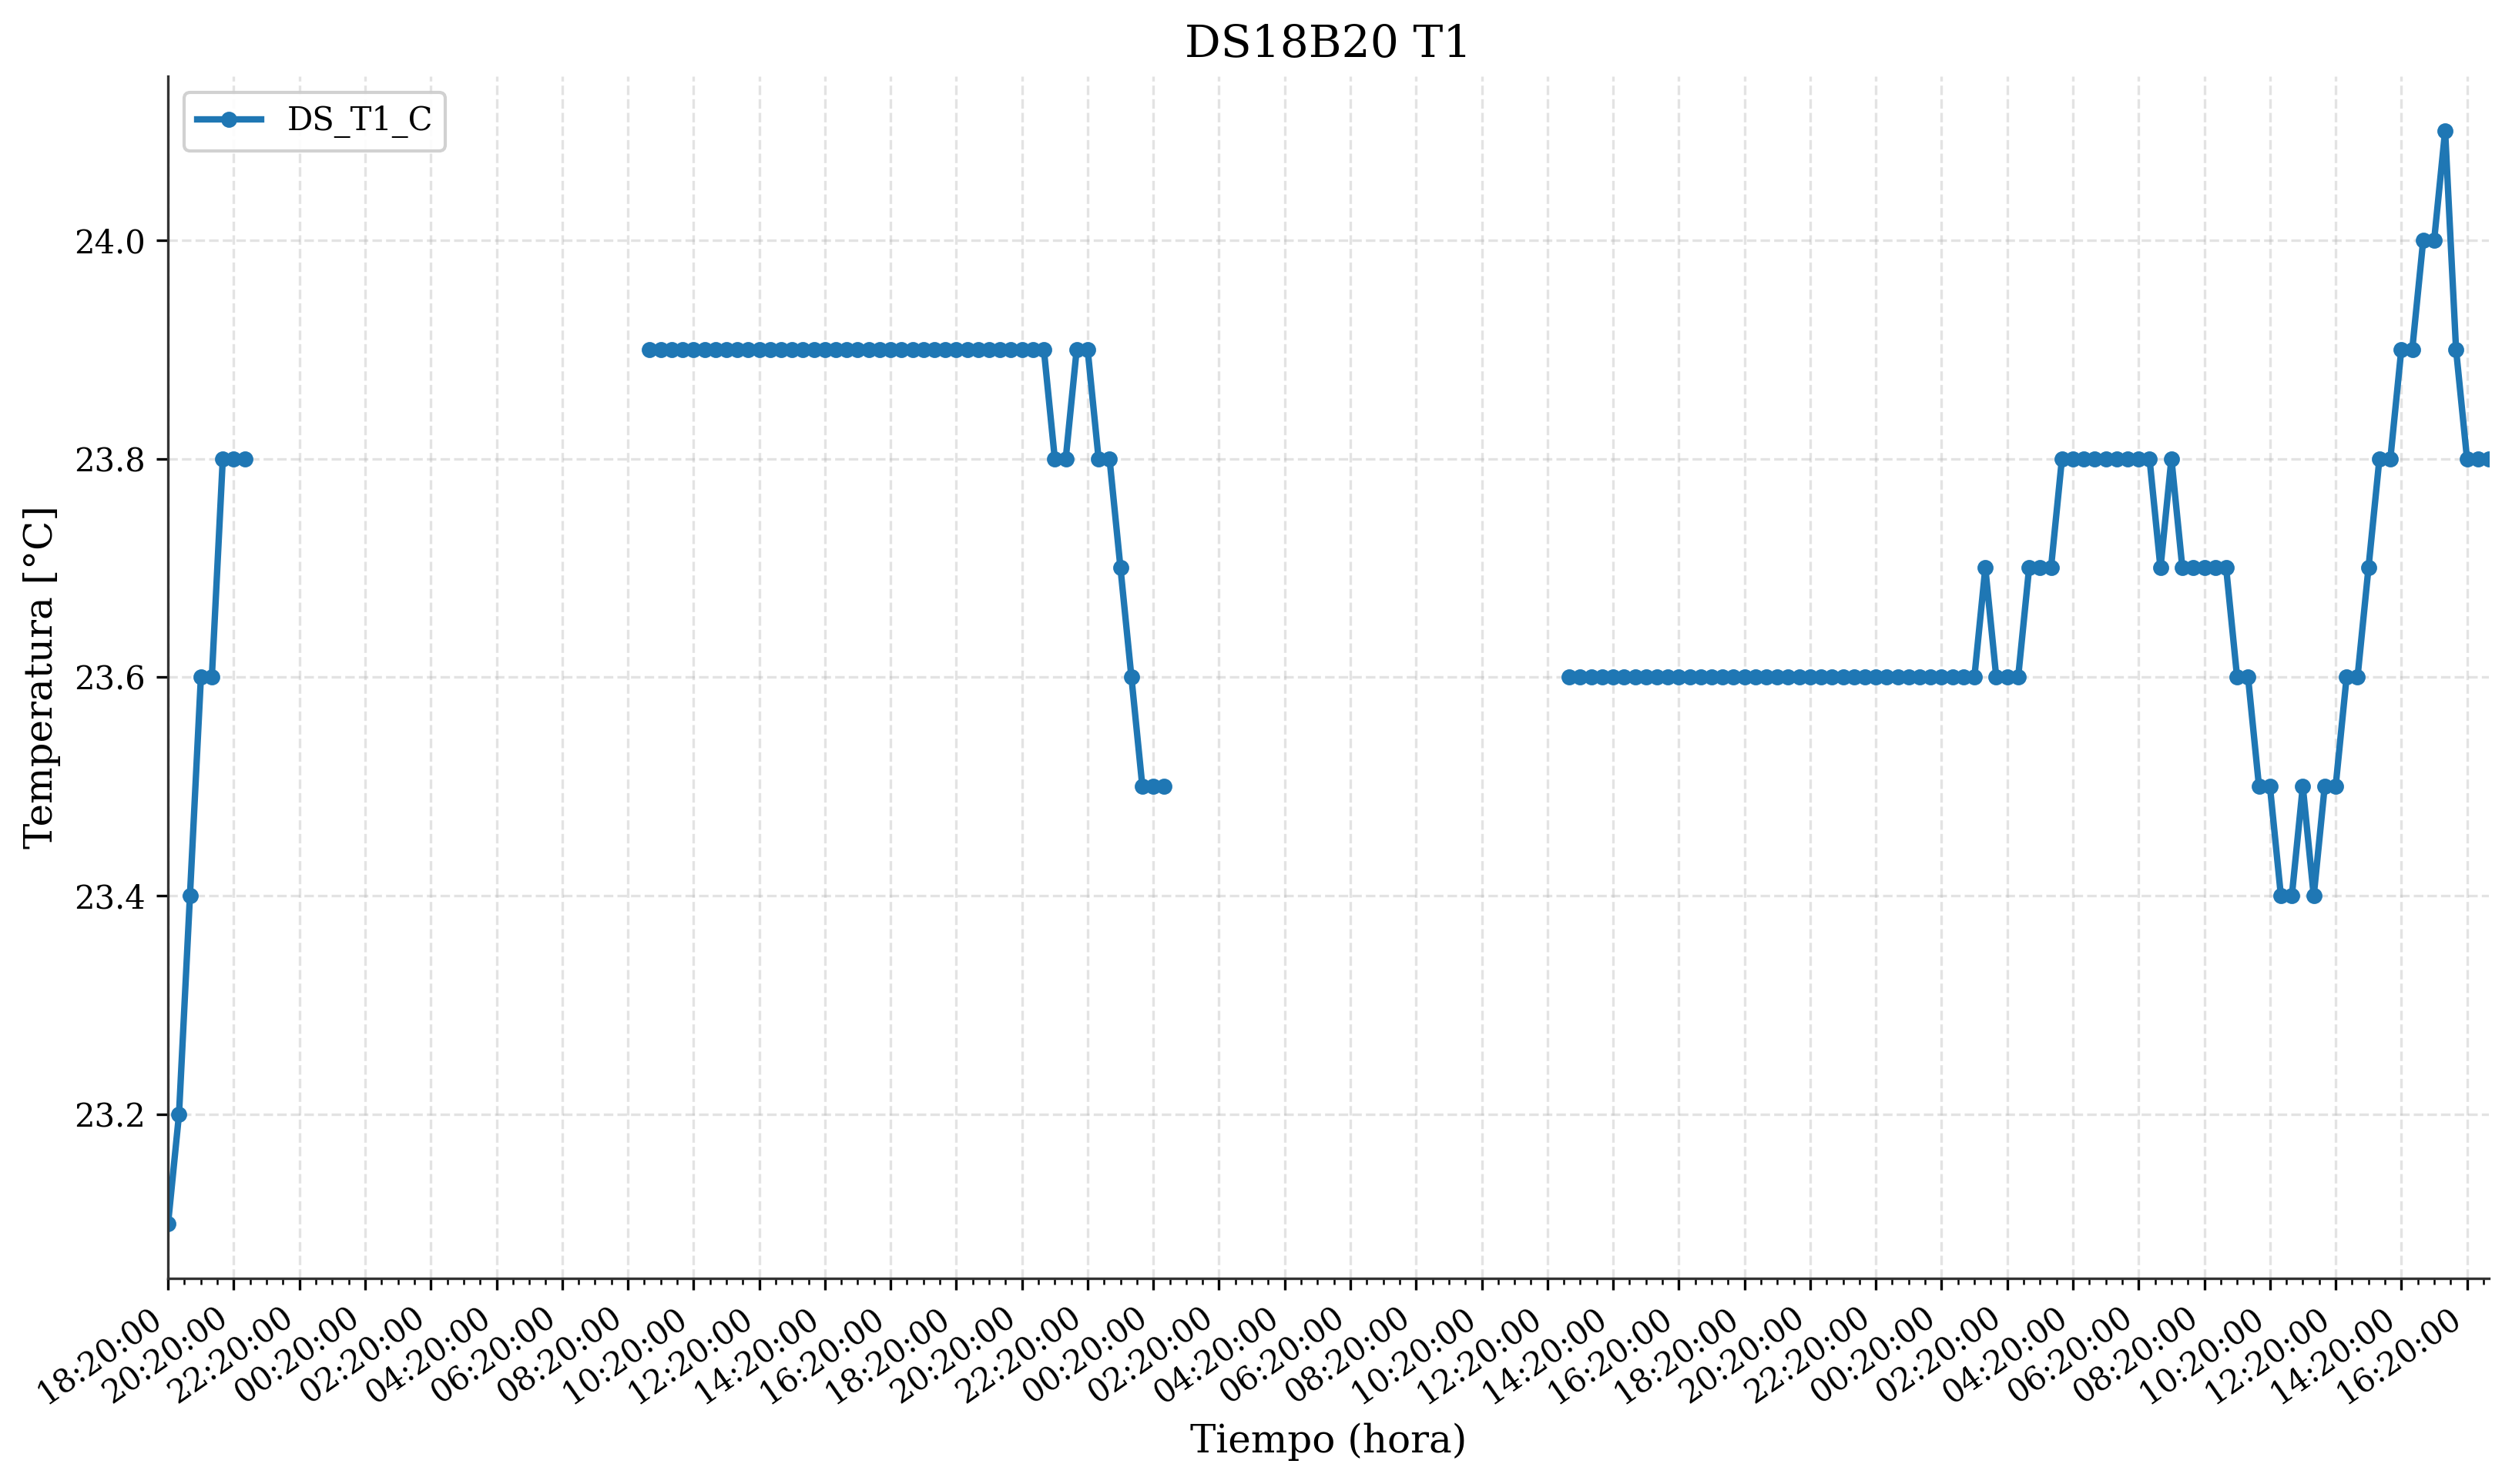

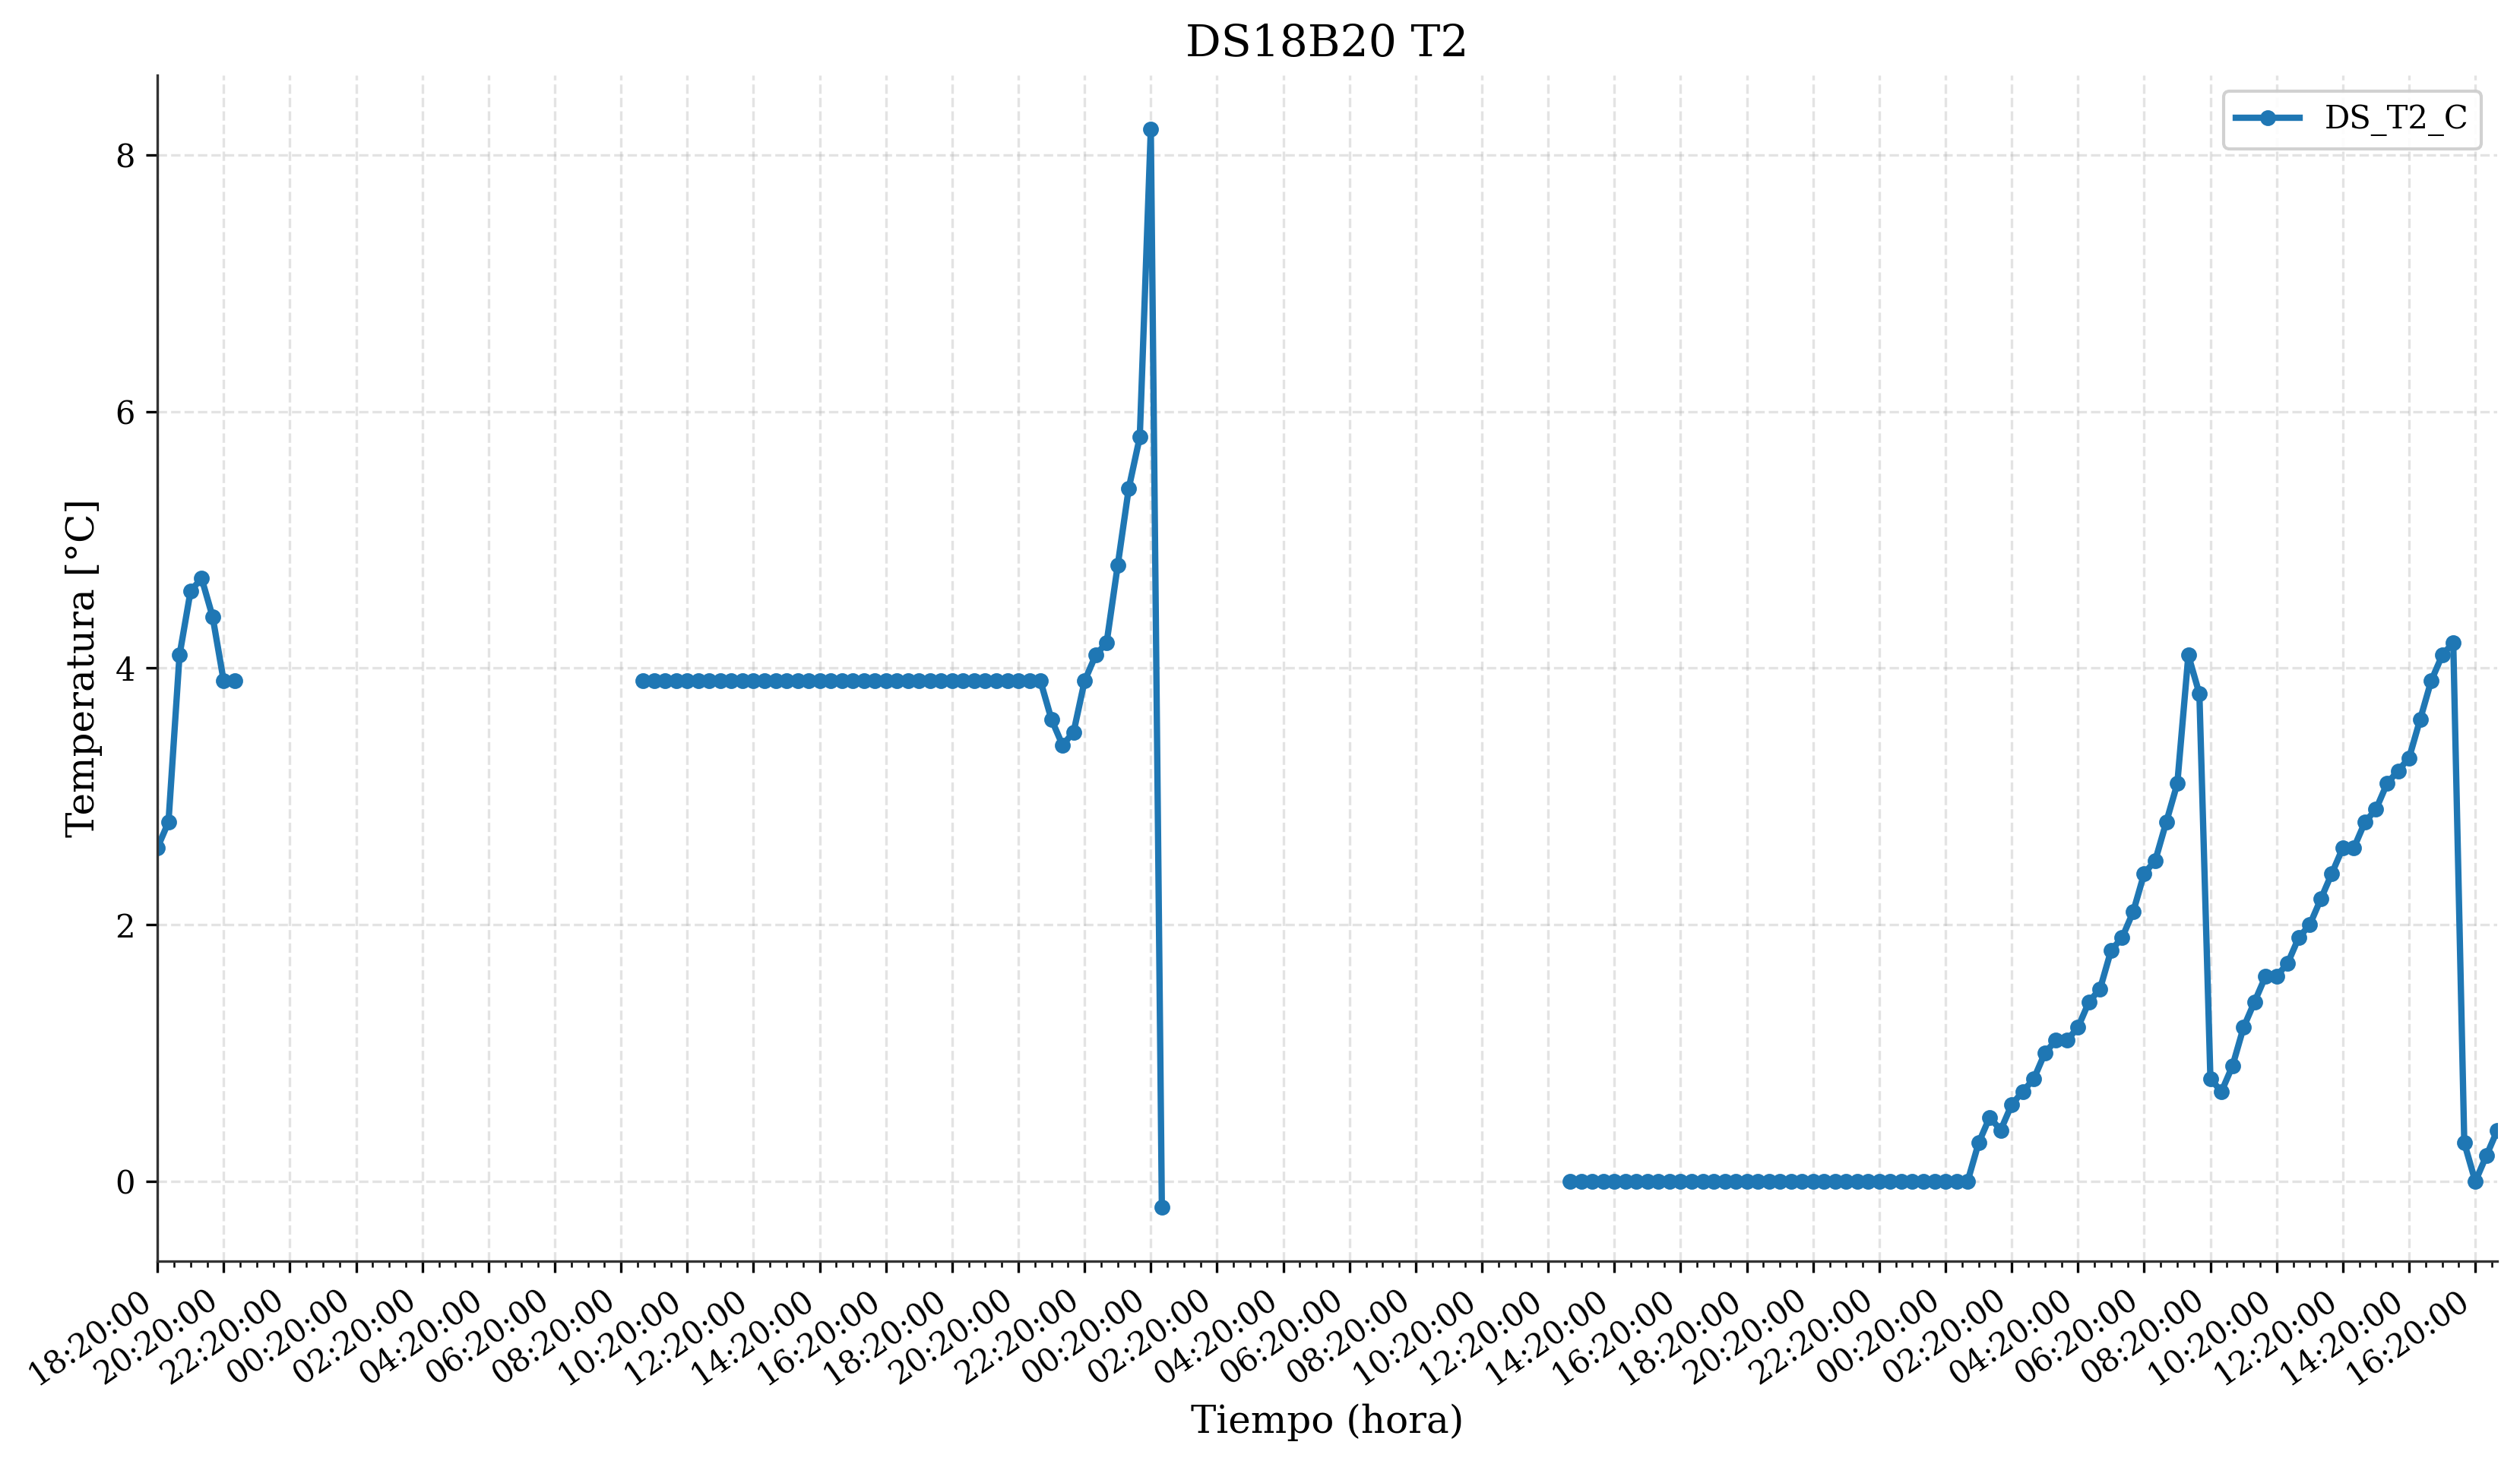

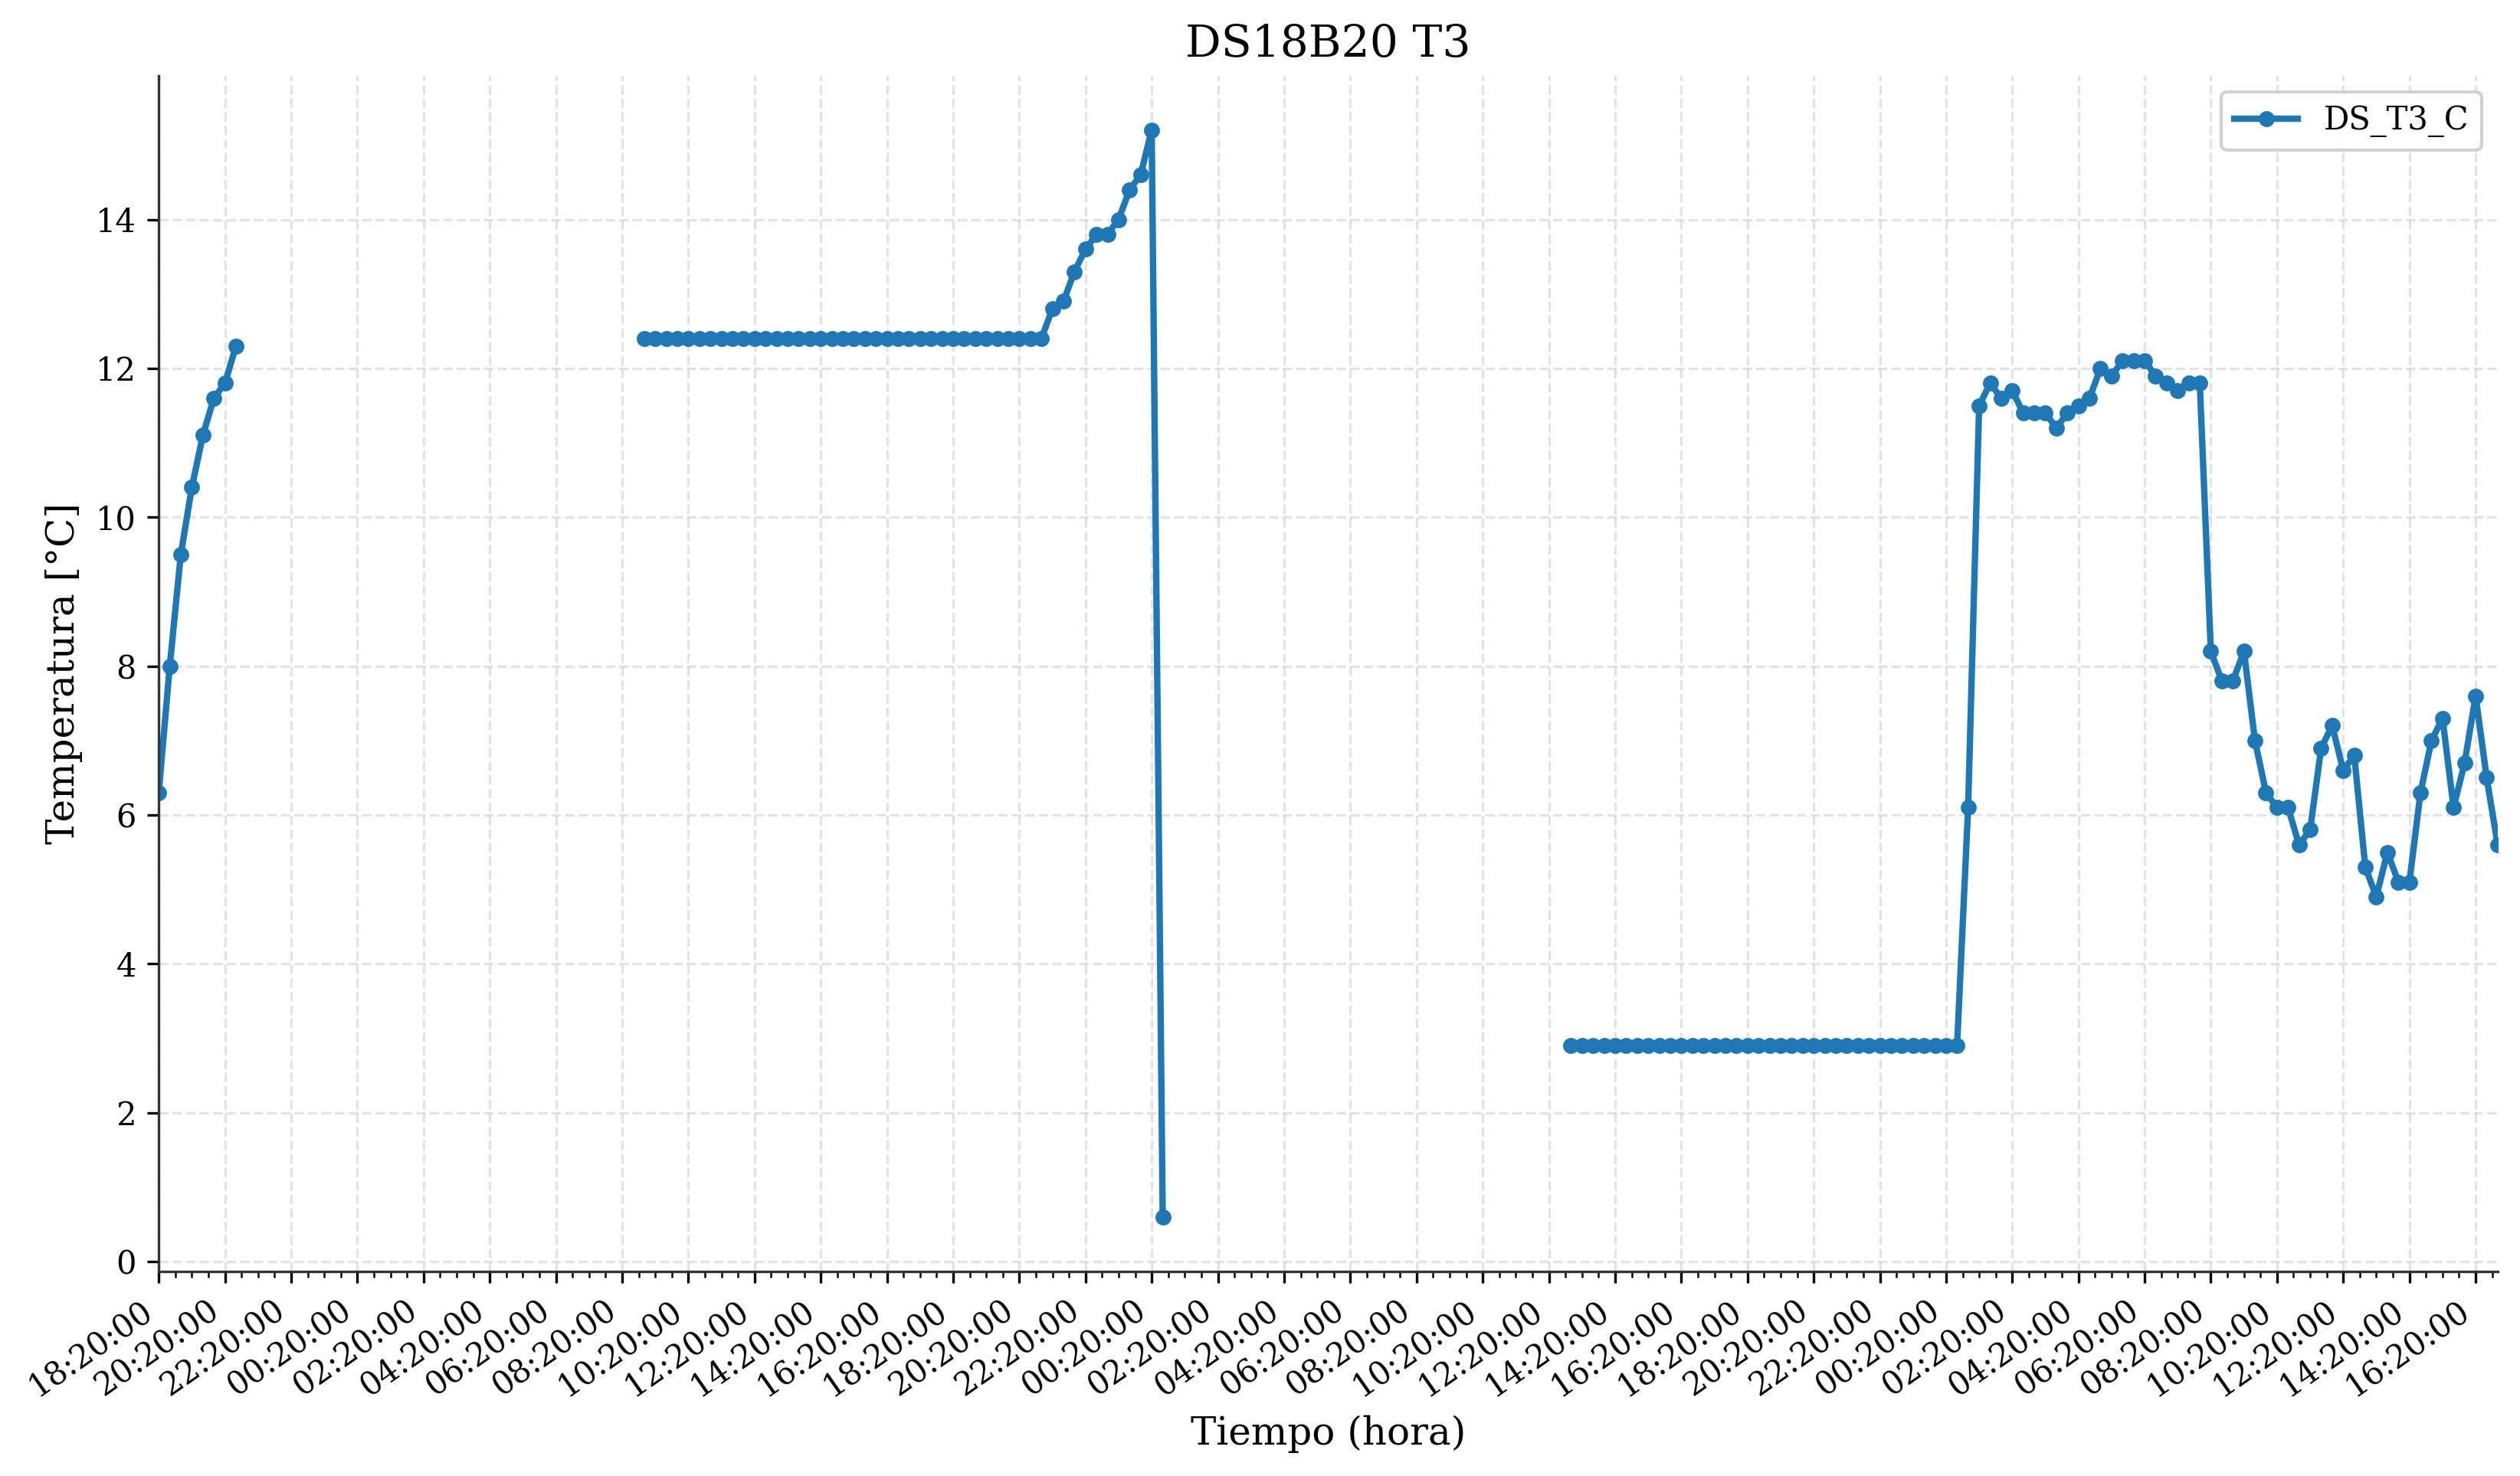

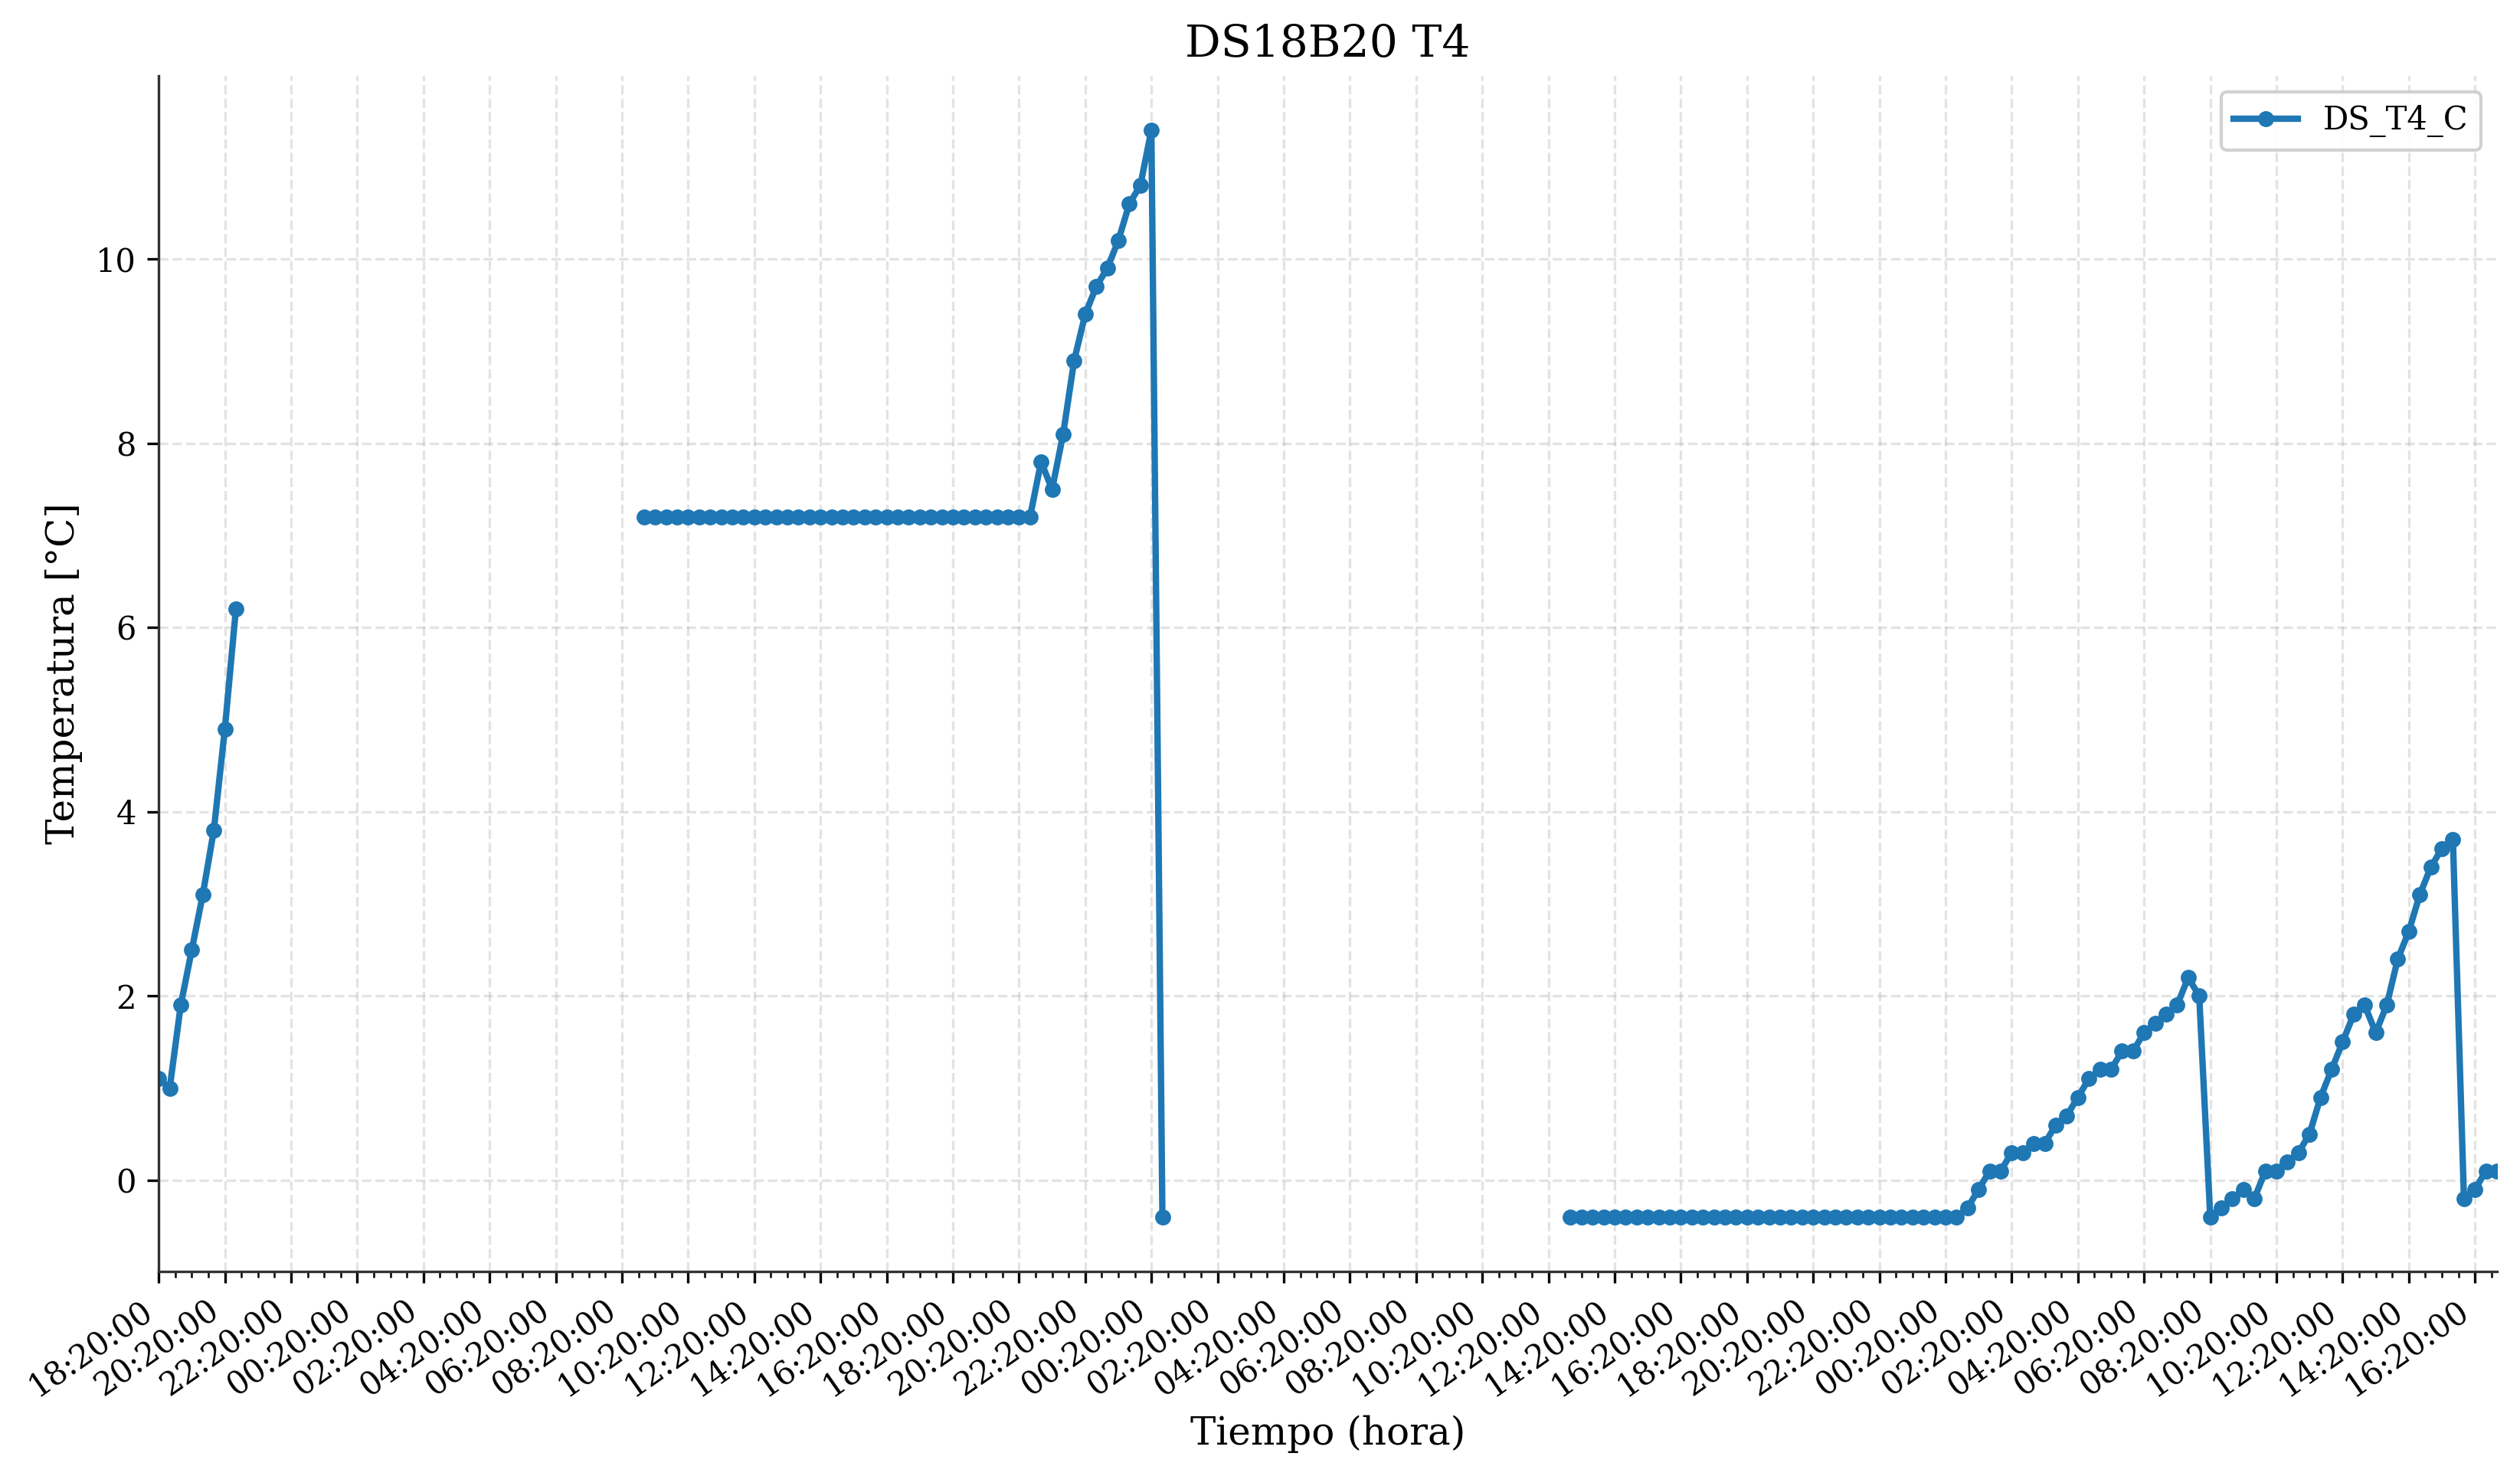

✅ Figuras generadas con formato de informe profesional.


In [13]:
# -*- coding: utf-8 -*-
"""
Graficación profesional (formato de informe):
- Gráficas globales (P1/P2, IR2/IR3, DS18B20 T1–T4)
- Gráficas individuales (cada sensor) con muestreo configurable
- Ejes HH:MM:SS, grilla anclada al primer dato
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Tuple

# ================== CONFIGURACIÓN GENERAL ==================
CSV_PATH       = "salida_unida.csv"  # Archivo combinado
OUT_PREFIX     = "fig_"
SAVE_PNGS      = True
SAVE_PDFS      = False
SHOW_PLOTS     = True
DPI            = 300
FIGSIZE        = (11, 6)
LINEWIDTH      = 2.0
MARKERSIZE     = 0
GRID_ALPHA     = 0.35

USE_ELAPSED    = False               # False → eje HH:MM:SS, True → elapsed_s
SAMPLE_INTERVAL = "30min"            # Muestreo individual (cambia a "15min" si quieres)
GLOBAL_MAJOR    = "120min"            # Grilla mayor global
GLOBAL_MINOR    = "30min"             # Grilla menor global
ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')

# ===========================================================

# ---- Estilo global de informe ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

# ================== FUNCIONES AUXILIARES ==================

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """Convierte la columna de hora (HH:MM:SS.mmm) en datetime continuo cosiendo medianoches."""
    t_norm = time_series.astype(str).str.replace(",", ".", regex=False).str.strip()
    base = "2000-01-01 "
    dt = pd.to_datetime(base + t_norm, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
    neg = dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    return dt + pd.to_timedelta(roll, unit="D")

def construir_x(df: pd.DataFrame) -> pd.Series:
    if USE_ELAPSED:
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
    else:
        return construir_tiempo_continuo(df["time"])

def set_time_ticks(ax, x_dt, major: Optional[str], minor: Optional[str]):
    """Configura ticks y grilla desde el primer dato, con formato HH:MM:SS y etiquetas rotadas."""
    start = pd.to_datetime(x_dt.iloc[0]).round('S')
    end = pd.to_datetime(x_dt.iloc[-1])
    ax.set_xlim(start, end)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    if major:
        majors = pd.date_range(start, end, freq=major)
        ax.set_xticks(majors)
    if minor:
        minors = pd.date_range(start, end, freq=minor)
        ax.set_xticks(minors, minor=True)
    ax.set_xlabel("Tiempo (hora)")

    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")


def aplicar_muestreo(x_dt, df, freq):
    """Muestrea el DataFrame a intervalos fijos usando 'nearest'."""
    tmp = df.copy().assign(_x=x_dt.values)
    tmp['_x_unique'] = tmp['_x'] + pd.to_timedelta(tmp.index, unit='ns')
    tmp = tmp.set_index("_x_unique").sort_index()
    df_s = tmp.resample(freq).nearest()
    return df_s.index.to_series().reset_index(drop=True), df_s.reset_index(drop=True)

def _save_and_show(fig, fname_base: str):
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def style_axes(ax, titulo, ylabel):
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    plt.tight_layout()

# ================== GRAFICACIÓN ==================

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname):
    fig, ax = plt.subplots()
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).any():
                ax.plot(x_dt, y, label=col)
    style_axes(ax, titulo, ylabel)
    set_time_ticks(ax, x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    _save_and_show(fig, fname)

def plot_individuales(x_dt, df):
    x_s, df_s = aplicar_muestreo(x_dt, df, SAMPLE_INTERVAL)
    columnas = [
        ("P1_mmHg","Presión P1","Presión [mmHg]"),
        ("P2_mmHg","Presión P2","Presión [mmHg]"),
        ("IR2_Obj_C","IR Canal 2 (Obj)","Temperatura [°C]"),
        ("IR3_Obj_C","IR Canal 3 (Obj)","Temperatura [°C]"),
        ("DS_T1_C","DS18B20 T1","Temperatura [°C]"),
        ("DS_T2_C","DS18B20 T2","Temperatura [°C]"),
        ("DS_T3_C","DS18B20 T3","Temperatura [°C]"),
        ("DS_T4_C","DS18B20 T4","Temperatura [°C]"),
    ]
    for col, title, ylabel in columnas:
        if col in df_s.columns:
            y = pd.to_numeric(df_s[col], errors="coerce")
            if np.isfinite(y).any():
                fig, ax = plt.subplots()
                ax.plot(x_s, y, "-o", label=col, markersize=4)
                style_axes(ax, title, ylabel)
                set_time_ticks(ax, x_s, GLOBAL_MAJOR, GLOBAL_MINOR)
                #set_time_ticks(ax, x_s, major=SAMPLE_INTERVAL, minor=None)
                _save_and_show(fig, f"{col}_individual")

def plot_global(x_dt, df):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
    # Presiones
    for c in ["P1_mmHg", "P2_mmHg"]:
        if c in df.columns:
            axes[0].plot(x_dt, df[c], label=c)
    style_axes(axes[0], "Presiones vs Tiempo", "Presión [mmHg]")
    set_time_ticks(axes[0], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    # IR
    for c in ["IR2_Obj_C", "IR3_Obj_C"]:
        if c in df.columns:
            axes[1].plot(x_dt, df[c], label=c)
    style_axes(axes[1], "Temperaturas IR (Objetivo)", "Temperatura [°C]")
    set_time_ticks(axes[1], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    # DS18B20
    for c in ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"]:
        if c in df.columns:
            axes[2].plot(x_dt, df[c], label=c)
    style_axes(axes[2], "Sensores DS18B20 (T1–T4)", "Temperatura [°C]")
    set_time_ticks(axes[2], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    plt.tight_layout()
    _save_and_show(fig, "global_subplots")

# ================== EJECUCIÓN ==================

def main():
    df = pd.read_csv(CSV_PATH)
    x_dt = construir_x(df)
    plot_global(x_dt, df)
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df, "Presiones", "Presión [mmHg]", "presiones_global")
    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df, "Temperaturas IR", "Temperatura [°C]", "ir_global")
    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df, "Temperaturas DS18B20", "Temperatura [°C]", "ds18b20_global")
    plot_individuales(x_dt, df)
    print(" Figuras generadas")

if __name__ == "__main__":
    main()


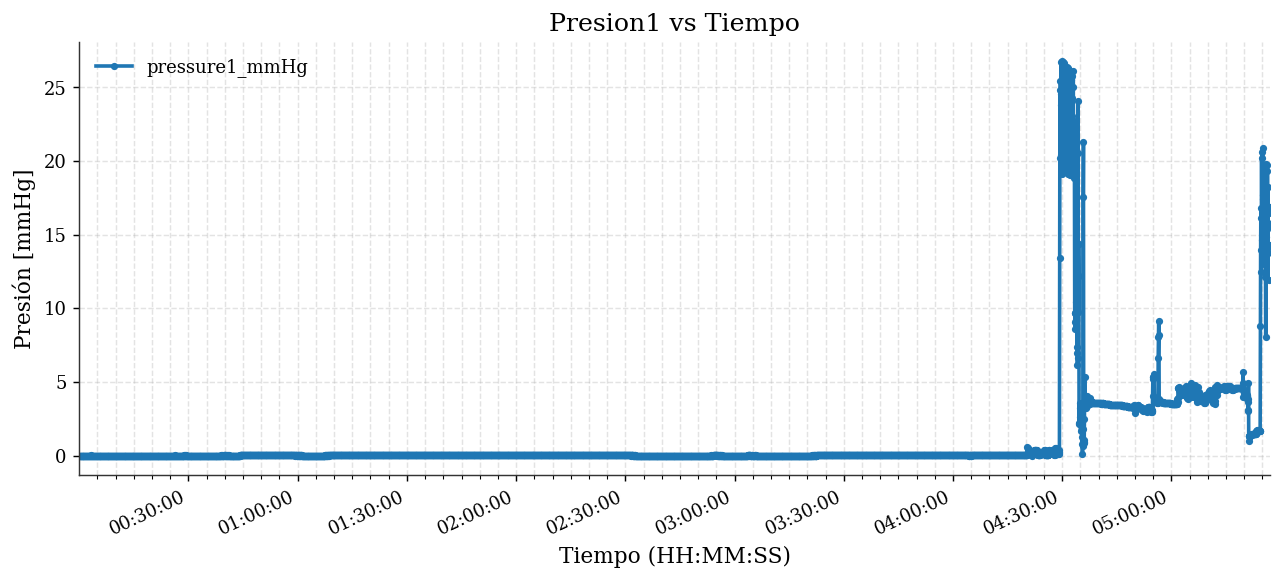

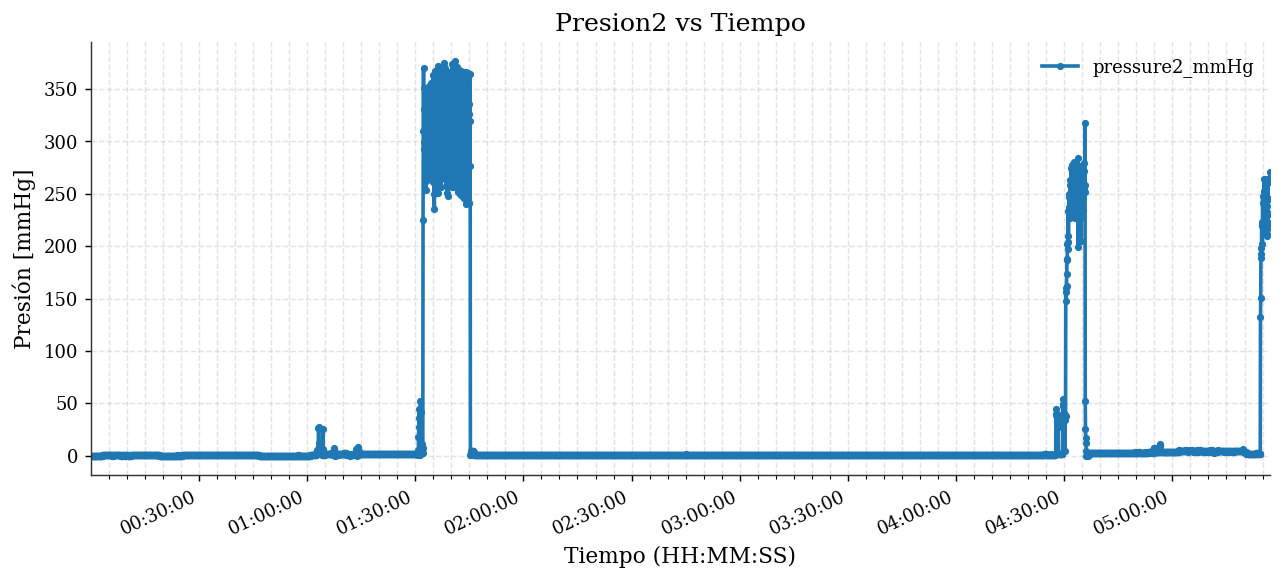

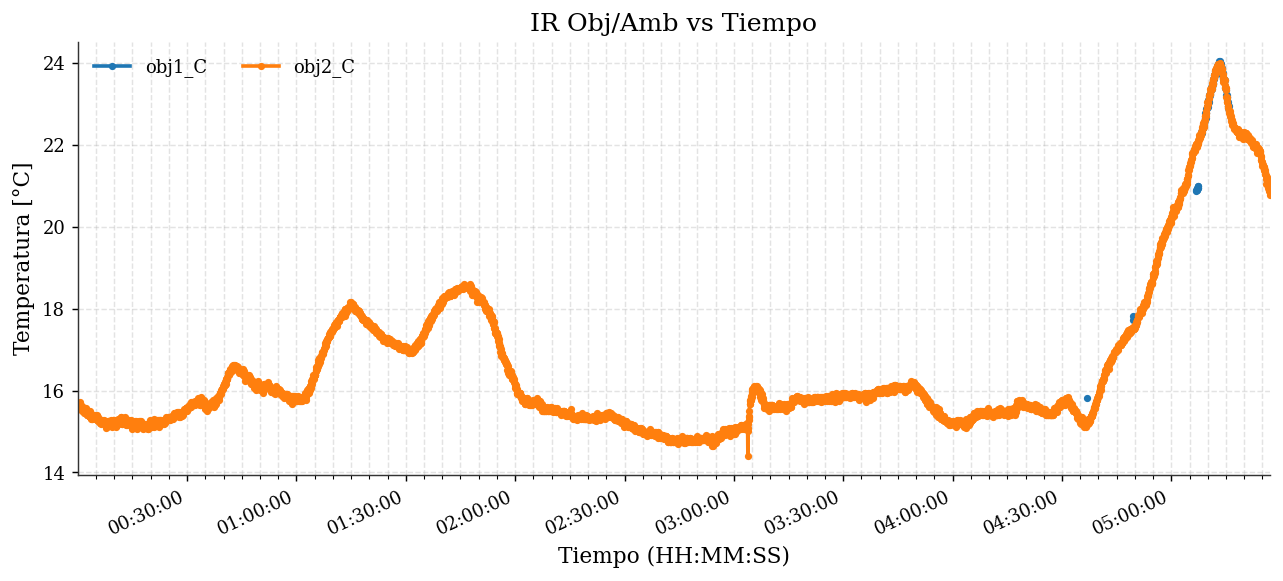

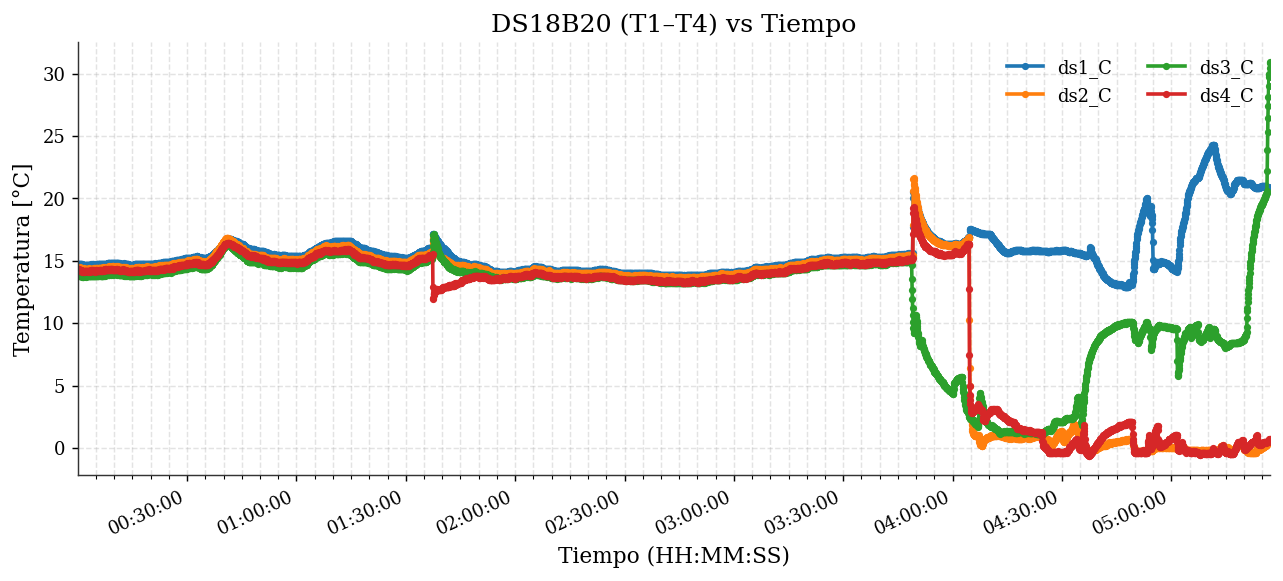

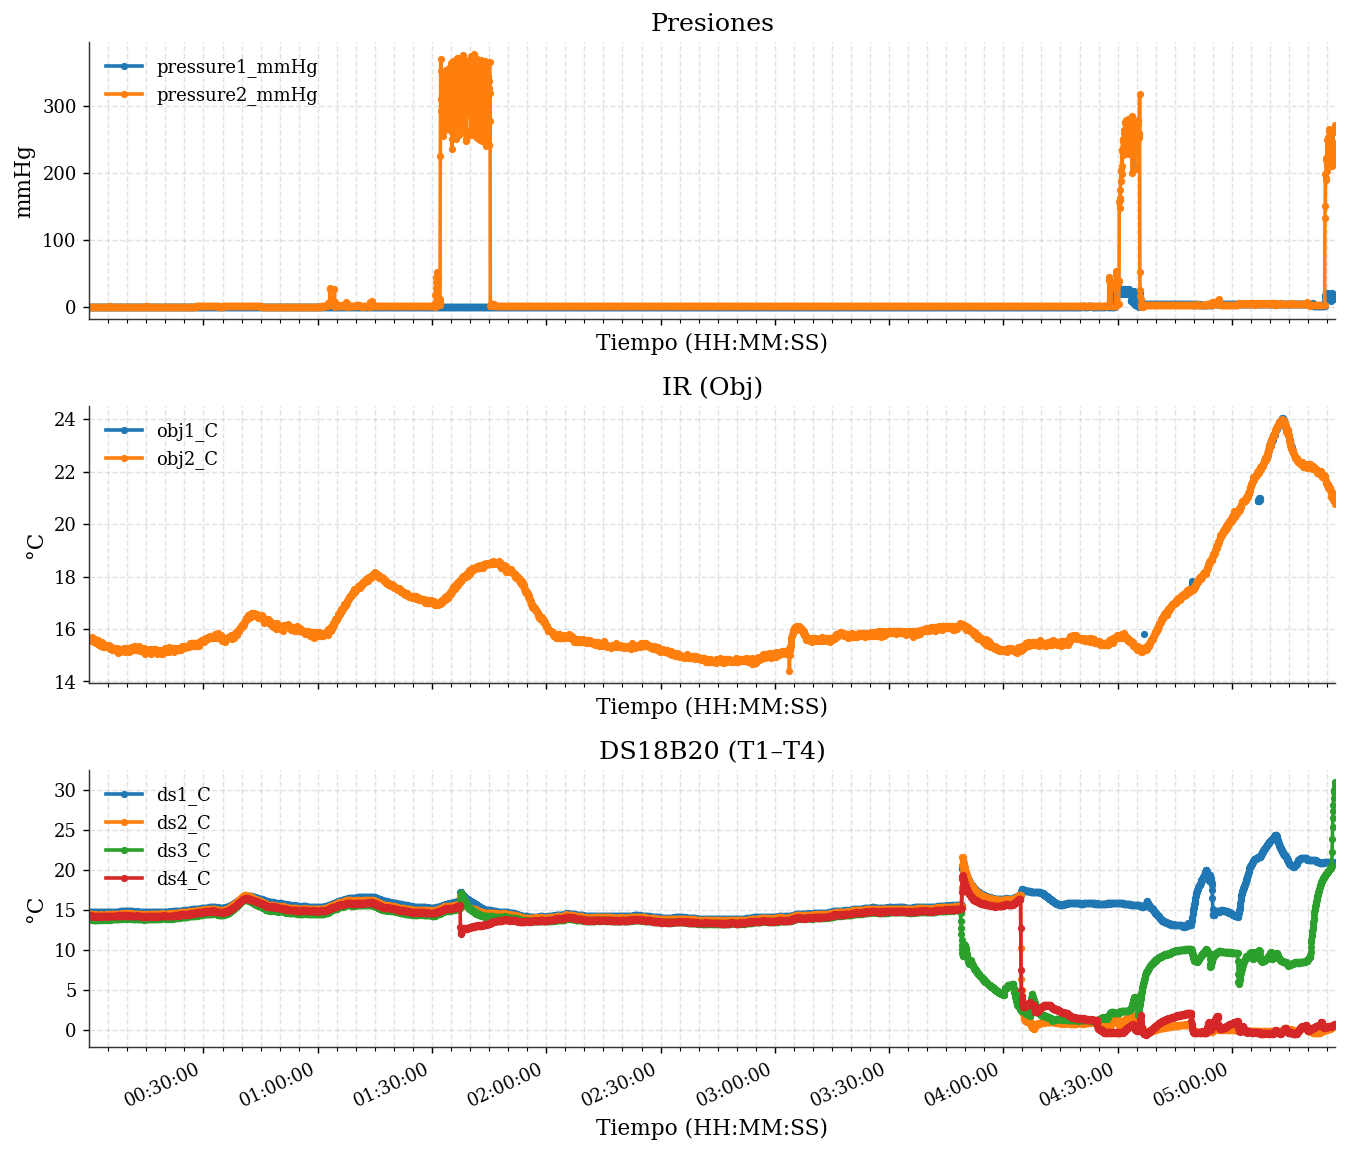

⏱ Ventana: 00:00:02 → 05:27:06  (~19624.0 s)
🧭 Un punto cada: 4 s  (fs_plot=0.250 Hz)
💾 Figuras en: /content/figs_secs_axis


In [25]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# ================== CONFIG ==================
CSV = "log.csv"                   # CSV con: millis, pressure1_mmHg, pressure2_mmHg, obj1_C, amb1_C, obj2_C, amb2_C, ds1_C, ds2_C, ds3_C, ds4_C
PLOT_EVERY_S = 4                # <- intervalo entre puntos en la gráfica (s). None = todos los puntos originales
AGG_IN_BIN = "mean"               # "mean" | "median" | "first" | "last" (cómo resumir dentro de cada ventana de PLOT_EVERY_S)

# Ventana a mostrar (elige UNA)
WINDOW = dict(mode="full")        # 1) todo
# WINDOW = dict(mode="range_s", start_s=60, end_s=600)     # 2) de 60 a 600 s desde inicio
# WINDOW = dict(mode="last_s", seconds=300)                 # 3) últimos 300 s

# Ticks (en segundos). Deja None para auto.
TICKS_MAJOR_S = None              # p. ej. 60 para marcas cada 1 min
TICKS_MINOR_S = None              # p. ej. 10 para marcas menores cada 10 s

SAVE_DPI = 300
OUTDIR = Path("figs_secs_axis")
OUTDIR.mkdir(parents=True, exist_ok=True)
# ============================================

# ---------- Carga y eje de tiempo absoluto (segundos) ----------
df = pd.read_csv(CSV).replace(["nan","NaN","NAN",""], np.nan)
t0 = float(df["millis"].iloc[0])
df["elapsed_s"] = (df["millis"] - t0) / 1000.0  # segundos absolutos desde el inicio (0.0, 0.1, ...)

# ---------- Selección de ventana ----------
def recortar_ventana_secs(dfin: pd.DataFrame, window: dict) -> pd.DataFrame:
    if window["mode"] == "full":
        return dfin
    elif window["mode"] == "range_s":
        s, e = float(window["start_s"]), float(window["end_s"])
        return dfin[(dfin["elapsed_s"] >= s) & (dfin["elapsed_s"] <= e)]
    elif window["mode"] == "last_s":
        span = float(window["seconds"])
        end = dfin["elapsed_s"].iloc[-1]
        start = max(dfin["elapsed_s"].iloc[0], end - span)
        return dfin[(dfin["elapsed_s"] >= start) & (dfin["elapsed_s"] <= end)]
    else:
        raise ValueError("WINDOW['mode'] no reconocido")

dfw = recortar_ventana_secs(df, WINDOW)
if dfw.empty:
    raise SystemExit("⚠️ La ventana elegida no tiene datos.")

# ---------- Remuestreo SOLO para dibujar (un punto cada PLOT_EVERY_S) ----------
def sample_for_plot_secs(dfin: pd.DataFrame, step_s=None, agg="mean") -> pd.DataFrame:
    if step_s is None:
        return dfin.copy()

    # Bin numérico por segundos (evita DateTimeIndex)
    step_s = float(step_s)
    # Para evitar problemas de flotantes en los bordes, sumamos un epsilon pequeñito
    eps = 1e-9
    bins = np.floor((dfin["elapsed_s"] + eps) / step_s).astype(int)

    # Selecciona solo columnas numéricas para agregar
    num_cols = dfin.select_dtypes(include=[np.number]).columns.tolist()
    tmp = dfin.copy()
    tmp["_bin_idx"] = bins

    if agg == "mean":
        grouped = tmp.groupby("_bin_idx")[num_cols].mean()
    elif agg == "median":
        grouped = tmp.groupby("_bin_idx")[num_cols].median()
    elif agg == "first":
        grouped = tmp.groupby("_bin_idx")[num_cols].first()
    elif agg == "last":
        grouped = tmp.groupby("_bin_idx")[num_cols].last()
    else:
        raise ValueError("AGG_IN_BIN no reconocido.")

    # Reconstruye el eje X como el centro del bin (o el inicio; aquí usamos centro)
    grouped = grouped.reset_index()
    grouped["elapsed_s"] = (grouped["_bin_idx"] + 0.5) * step_s
    grouped = grouped.drop(columns=["_bin_idx"]).sort_values("elapsed_s").reset_index(drop=True)
    return grouped

dfp = sample_for_plot_secs(dfw, PLOT_EVERY_S, AGG_IN_BIN)
x = dfp["elapsed_s"].to_numpy()

# ---------- Formateo de eje X en HH:MM:SS (sin fechas) ----------
def sec_to_hms(seconds: float) -> str:
    s = int(round(seconds))
    h = s // 3600
    m = (s % 3600) // 60
    s2 = s % 60
    return f"{h:02d}:{m:02d}:{s2:02d}"

def pick_step(total_s: float) -> int:
    """Escoge un paso 'bonito' para ticks, en segundos."""
    candidates = [1,2,5,10,15,20,30,60,120,300,600,900,1200,1800,3600]
    target = max(1, int(total_s / 8))  # ~8 marcas mayores
    return min(candidates, key=lambda c: abs(c - target))

def style_time_axis_seconds(ax, xvals, major_s=None, minor_s=None, rotate=25):
    xmin, xmax = float(np.nanmin(xvals)), float(np.nanmax(xvals))
    ax.set_xlim(xmin, xmax)

    # Elegir pasos automáticos si no se definen
    total_s = max(1.0, xmax - xmin)
    if major_s is None:
        major_s = pick_step(total_s)
    # minor ~ 1/3 del mayor, redondeado a una opción "bonita"
    if minor_s is None:
        minor_candidates = [1,2,5,10,15,20,30,60,120,300]
        minor_target = max(1, int(major_s / 3))
        minor_s = min(minor_candidates, key=lambda c: abs(c - minor_target))

    # Construir ticks
    major_ticks = np.arange(np.ceil(xmin / major_s) * major_s, xmax + 1e-9, major_s)
    minor_ticks = np.arange(np.ceil(xmin / minor_s) * minor_s, xmax + 1e-9, minor_s)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: sec_to_hms(v)))
    ax.set_xlabel("Tiempo (HH:MM:SS)")

    for lab in ax.get_xticklabels():
        lab.set_rotation(rotate)
        lab.set_horizontalalignment("right")

    ax.grid(True, which="both", ls="--", alpha=0.35)
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

# ---------- Utilidades de trazado ----------
def plot_series(cols, title, ylabel, fname=None):
    fig, ax = plt.subplots(figsize=(10, 4.6), dpi=130)
    for c in cols:
        if c in dfp.columns:
            y = pd.to_numeric(dfp[c], errors="coerce")
            if np.isfinite(y).any():
                ax.plot(x, y, marker="o", markersize=3, label=c)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(ncol=2, framealpha=0.9)
    style_time_axis_seconds(ax, x, TICKS_MAJOR_S, TICKS_MINOR_S)
    fig.tight_layout()
    if fname:
        fig.savefig(OUTDIR / fname, dpi=SAVE_DPI, bbox_inches="tight")
    plt.show()

# ---------- Gráficas individuales ----------
plot_series(["pressure1_mmHg"],
            f"Presion1 vs Tiempo", "Presión [mmHg]", "presiones1.png")
plot_series(["pressure2_mmHg"],
            f"Presion2 vs Tiempo", "Presión [mmHg]", "presiones2.png")

plot_series(["obj1_C","obj2_C"],
            f"IR Obj/Amb vs Tiempo", "Temperatura [°C]", "ir.png")

plot_series(["ds1_C","ds2_C","ds3_C","ds4_C"],
            f"DS18B20 (T1–T4) vs Tiempo", "Temperatura [°C]", "ds.png")

# ---------- Figura global con 3 subplots ----------
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10.5, 9), dpi=130)

for c in ["pressure1_mmHg","pressure2_mmHg"]:
    if c in dfp.columns:
        axes[0].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[0].set_title("Presiones"); axes[0].set_ylabel("mmHg"); axes[0].legend()
style_time_axis_seconds(axes[0], x, TICKS_MAJOR_S, TICKS_MINOR_S)

for c in ["obj1_C","obj2_C"]:
    if c in dfp.columns:
        axes[1].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[1].set_title("IR (Obj)"); axes[1].set_ylabel("°C"); axes[1].legend()
style_time_axis_seconds(axes[1], x, TICKS_MAJOR_S, TICKS_MINOR_S)

for c in ["ds1_C","ds2_C","ds3_C","ds4_C"]:
    if c in dfp.columns:
        axes[2].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[2].set_title("DS18B20 (T1–T4)"); axes[2].set_ylabel("°C"); axes[2].legend()
style_time_axis_seconds(axes[2], x, TICKS_MAJOR_S, TICKS_MINOR_S)

fig.tight_layout()
fig.savefig(OUTDIR / "global.png", dpi=SAVE_DPI, bbox_inches="tight")
plt.show()

# ---------- Info ----------
dur = x[-1] - x[0]
fs_plot = (1.0 / PLOT_EVERY_S) if PLOT_EVERY_S else None
print(f"⏱ Ventana: {sec_to_hms(x[0])} → {sec_to_hms(x[-1])}  (~{dur:.1f} s)")
print(f"🧭 Un punto cada: {PLOT_EVERY_S} s  (fs_plot={'{:.3f} Hz'.format(fs_plot) if fs_plot else 'original'})")
print("💾 Figuras en:", OUTDIR.resolve())



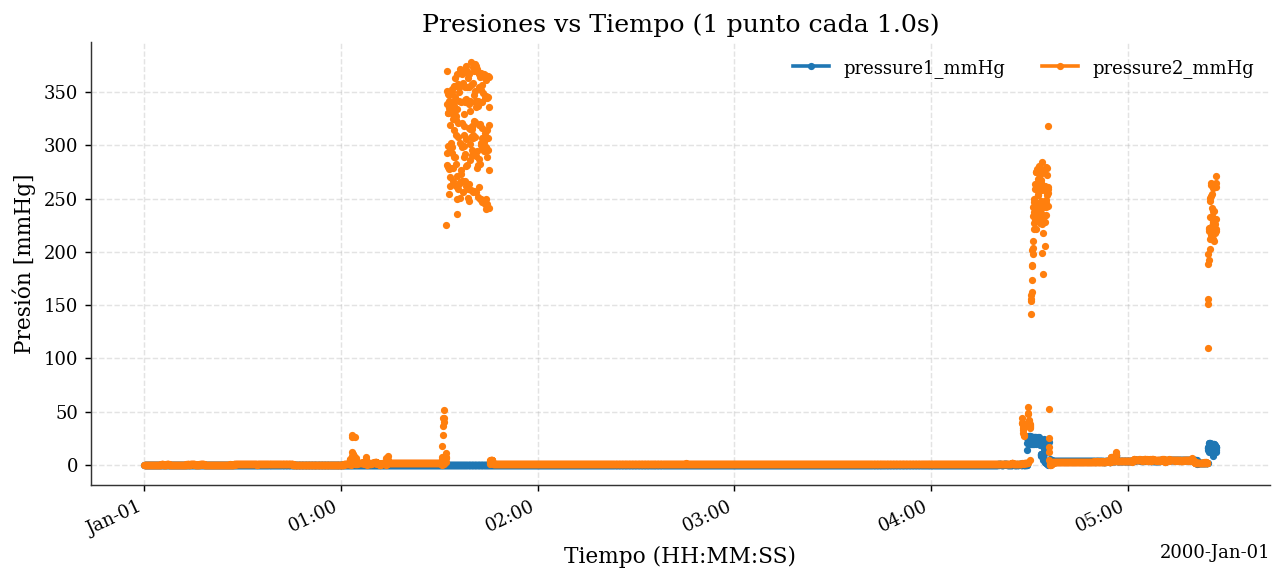

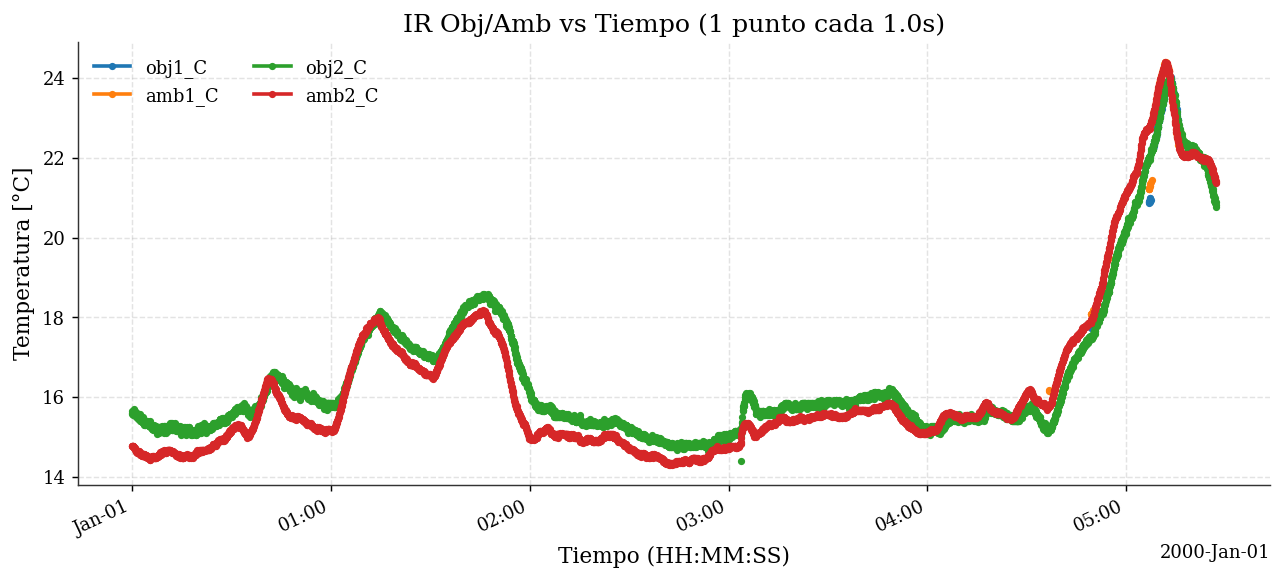

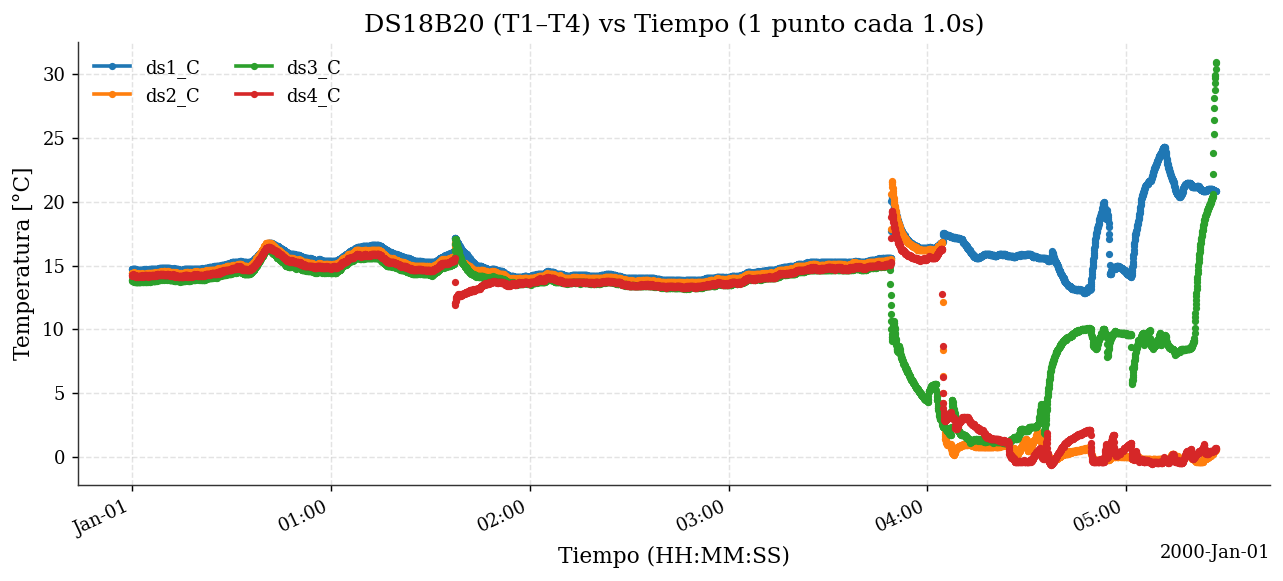

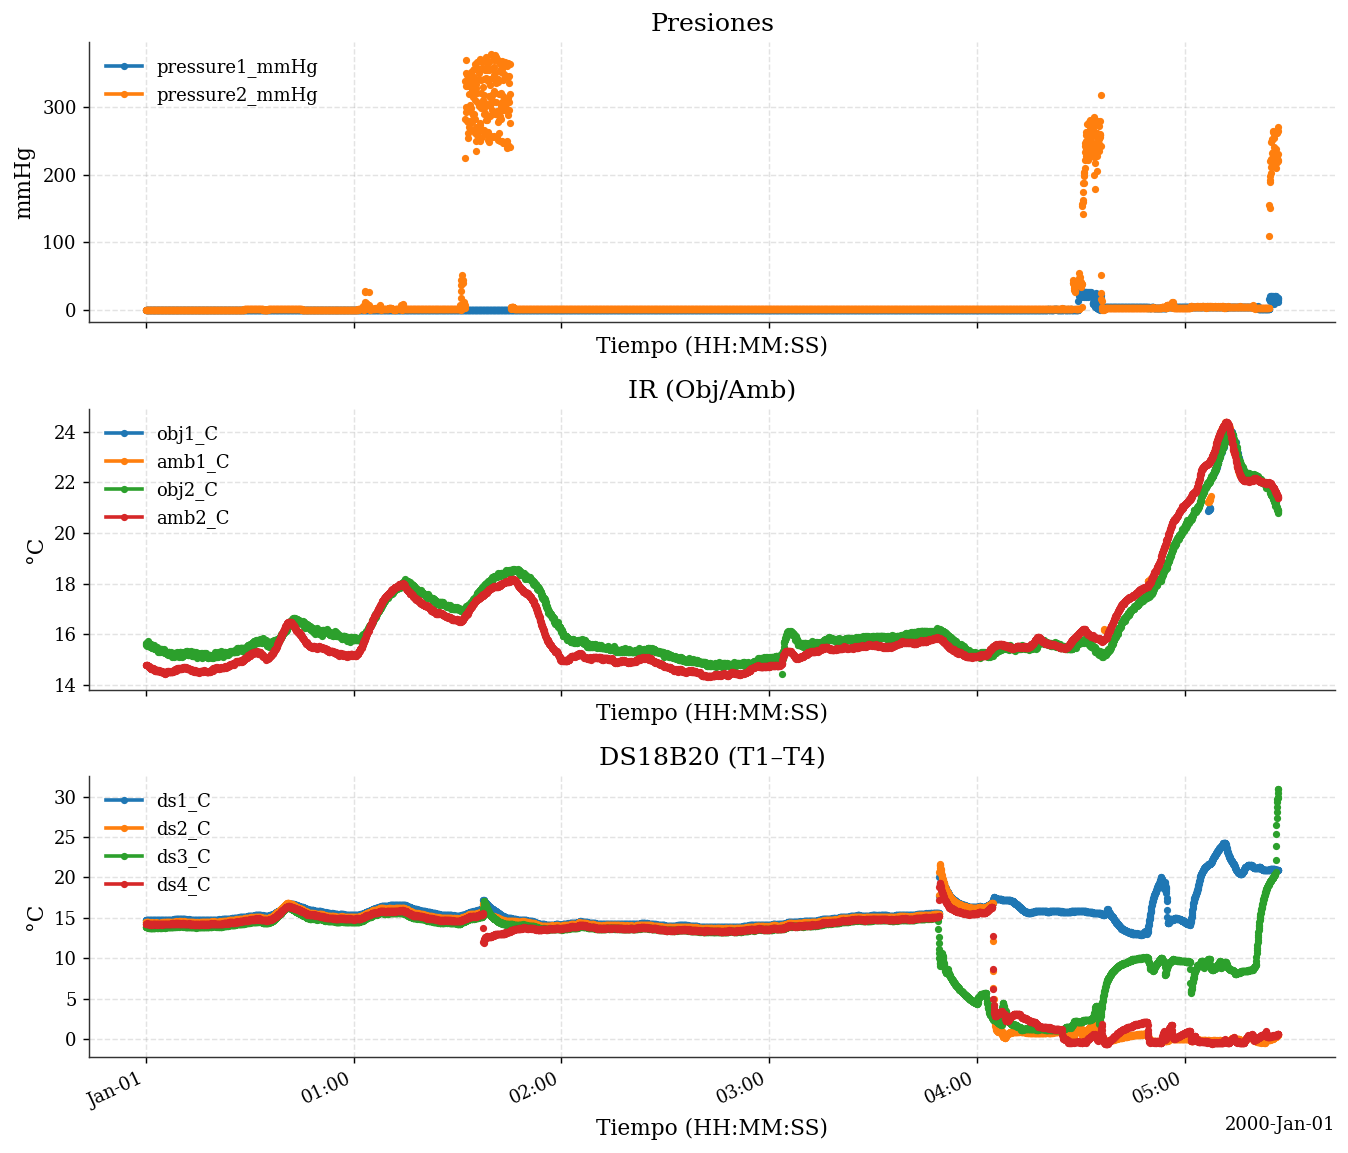

📄 Archivo: /content/log.csv
⏱ Ventana: 2000-01-01 00:00:00 → 2000-01-01 05:27:05  (~19625.0 s)
🧭 Un punto cada: 1.0 s  (fs_plot=1.000)
💾 Figuras en: /content/figs_plot_every


In [37]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ================== CONFIG ==================
CSV = "log.csv"                  # tu CSV con columnas: millis, pressure1_mmHg, ...
PLOT_EVERY_S = 1.0               # <- intervalo entre puntos en la gráfica (segundos). None = todos los puntos
AGG_IN_BIN = "mean"              # cómo resumir dentro de cada ventana de PLOT_EVERY_S: "mean" | "median" | "first" | "last"

# Ventana a mostrar (elige UNA)
WINDOW = dict(mode="full")       # 1) todo
# WINDOW = dict(mode="relative", start_s=60, end_s=600)                   # 2) de 60 a 600 s desde inicio
# WINDOW = dict(mode="last", minutes=10)                                   # 3) últimos 10 min
# WINDOW = dict(mode="absolute", start="00:03:00", end="00:10:00")         # 4) HH:MM:SS relativos al inicio

SAVE_DPI = 300
OUTDIR = Path("figs_plot_every")
OUTDIR.mkdir(parents=True, exist_ok=True)
# ============================================

# ---------- Carga y eje de tiempo ----------
df = pd.read_csv(CSV).replace(["nan","NaN","NAN",""], np.nan)
t0 = df["millis"].iloc[0]
df["elapsed_s"] = (df["millis"] - t0) / 1000.0
ZERO = pd.Timestamp("2000-01-01")
df["t_dt"] = ZERO + pd.to_timedelta(df["elapsed_s"], unit="s")
df = df.set_index("t_dt").sort_index()

# ---------- Selección de ventana ----------
def recortar_ventana(dfin, window):
    if window["mode"] == "full":
        return dfin
    elif window["mode"] == "relative":
        s, e = window["start_s"], window["end_s"]
        return dfin.loc[ZERO + pd.to_timedelta(s, "s"): ZERO + pd.to_timedelta(e, "s")]
    elif window["mode"] == "last":
        end = dfin.index[-1]
        start = end - pd.to_timedelta(window["minutes"], "m")
        return dfin.loc[start:end]
    elif window["mode"] == "absolute":
        def to_td(hms):
            ts = pd.to_datetime(hms).time()
            return pd.Timedelta(hours=ts.hour, minutes=ts.minute, seconds=ts.second)
        return dfin.loc[ZERO + to_td(window["start"]): ZERO + to_td(window["end"])]
    else:
        raise ValueError("WINDOW['mode'] no reconocido")
dfw = recortar_ventana(df, WINDOW)
if dfw.empty:
    raise SystemExit("⚠️ La ventana elegida no tiene datos.")

# ---------- Remuestreo SOLO para graficar ----------
def para_grafica(dfin, step_s=None, agg="mean"):
    """Devuelve una versión remuestreada donde hay UN punto cada 'step_s' segundos."""
    if step_s is None:
        return dfin.copy()  # todos los puntos originales
    rule = pd.to_timedelta(step_s, unit="s")   # tamaño de cada bin temporal
    # Agrega por ventanas consecutivas del tamaño 'rule'
    out = dfin.resample(rule).agg(agg)
    # Si quieres evitar huecos, podrías .interpolate(), pero normalmente dejamos gaps si no hay datos.
    return out

dfp = para_grafica(dfw, PLOT_EVERY_S, AGG_IN_BIN)
x = dfp.index

# ---------- Utilidades de estilo ----------
def style_time_axis(ax, rotate=25):
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.set_xlabel("Tiempo (HH:MM:SS)")
    for lab in ax.get_xticklabels():
        lab.set_rotation(rotate)
        lab.set_horizontalalignment("right")
    ax.grid(True, which="both", ls="--", alpha=0.35)
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

def plot_series(cols, title, ylabel, fname=None):
    fig, ax = plt.subplots(figsize=(10, 4.6), dpi=130)
    for c in cols:
        if c in dfp.columns:
            y = pd.to_numeric(dfp[c], errors="coerce")
            if np.isfinite(y).any():
                ax.plot(x, y, marker="o", markersize=3, label=c)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(ncol=2, framealpha=0.9)
    style_time_axis(ax)
    fig.tight_layout()
    if fname:
        fig.savefig(OUTDIR / fname, dpi=SAVE_DPI, bbox_inches="tight")
    plt.show()

# ---------- Gráficas individuales ----------
plot_series(["pressure1_mmHg","pressure2_mmHg"],
            f"Presiones vs Tiempo (1 punto cada {PLOT_EVERY_S}s)", "Presión [mmHg]", "presiones.png")

plot_series(["obj1_C","amb1_C","obj2_C","amb2_C"],
            f"IR Obj/Amb vs Tiempo (1 punto cada {PLOT_EVERY_S}s)", "Temperatura [°C]", "ir.png")

plot_series(["ds1_C","ds2_C","ds3_C","ds4_C"],
            f"DS18B20 (T1–T4) vs Tiempo (1 punto cada {PLOT_EVERY_S}s)", "Temperatura [°C]", "ds.png")

# ---------- Figura global con 3 subplots ----------
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10.5, 9), dpi=130)

for c in ["pressure1_mmHg","pressure2_mmHg"]:
    if c in dfp.columns: axes[0].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[0].set_title("Presiones"); axes[0].set_ylabel("mmHg"); axes[0].legend(); style_time_axis(axes[0])

for c in ["obj1_C","amb1_C","obj2_C","amb2_C"]:
    if c in dfp.columns: axes[1].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[1].set_title("IR (Obj/Amb)"); axes[1].set_ylabel("°C"); axes[1].legend(); style_time_axis(axes[1])

for c in ["ds1_C","ds2_C","ds3_C","ds4_C"]:
    if c in dfp.columns: axes[2].plot(x, dfp[c], marker="o", markersize=3, label=c)
axes[2].set_title("DS18B20 (T1–T4)"); axes[2].set_ylabel("°C"); axes[2].legend(); style_time_axis(axes[2])

fig.tight_layout()
fig.savefig(OUTDIR / "global.png", dpi=SAVE_DPI, bbox_inches="tight")
plt.show()

# ---------- Info ----------
total_s = (x[-1] - x[0]).total_seconds()
fs_plot = (1.0 / PLOT_EVERY_S) if PLOT_EVERY_S else None
print("📄 Archivo:", Path(CSV).resolve())
print(f"⏱ Ventana: {x[0]} → {x[-1]}  (~{total_s:.1f} s)")
print(f"🧭 Un punto cada: {PLOT_EVERY_S} s  (fs_plot={'{:.3f}'.format(fs_plot) if fs_plot else 'original'})")
print("💾 Figuras en:", OUTDIR.resolve())


In [18]:
# Colab-ready cell: renders and DISPLAYS a high-resolution flowchart (PNG + SVG) of the ESP32 sketch.
# - If running on Google Colab and Graphviz isn't available, it will try to install it automatically.
# - It shows the SVG inline (best quality) and also writes a high-dpi PNG for download.

import sys, subprocess, importlib.util, os
from IPython.display import display, SVG, Image

def in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

def ensure_graphviz():
    # Check Python package
    if importlib.util.find_spec("graphviz") is None:
        if in_colab():
            # Install system graphviz and python package silently
            try:
                subprocess.check_call("apt-get -qq update && apt-get -qq install -y graphviz", shell=True)
            except Exception as e:
                print("Aviso: no se pudo instalar graphviz vía apt-get:", e)
            try:
                subprocess.check_call(f"{sys.executable} -m pip -q install graphviz", shell=True)
            except Exception as e:
                print("Aviso: no se pudo instalar el paquete graphviz de Python:", e)
        else:
            print("⚠️ El paquete 'graphviz' no está instalado. En Colab se instalará automáticamente.")
    # Import after (possible) install
    global Digraph
    from graphviz import Digraph

ensure_graphviz()
from graphviz import Digraph  # now safe

# ---------------- Create diagram ----------------
dot = Digraph("Flow_ESP32_Biomed", comment="Diagrama de flujo del sketch (WiFi, MQTT, TM7711, MLX90614, DS18B20)")

# Save both formats
dot.format = "png"  # we'll render PNG and also SVG below

# High resolution / styling
dot.attr(rankdir="TB")
dot.attr("graph", dpi="600", fontname="Helvetica", fontsize="14")   # 600 DPI for PNG
dot.attr("node", fontname="Helvetica", fontsize="12", shape="box")
dot.attr("edge", fontname="Helvetica", fontsize="11")

# Top-level nodes
dot.node("START", "Arranque", shape="ellipse")
dot.node("SETUP", "setup()", shape="box")
dot.node("LOOP", "loop()", shape="diamond")
dot.edge("START", "SETUP")
dot.edge("SETUP", "LOOP")

# --- setup() ---
with dot.subgraph(name="cluster_setup") as c:
    c.attr(label="SETUP – inicialización", fontsize="14", style="rounded", color="#777777")
    c.node("S0", "delay(1000)")
    c.node("S1", "Serial.begin(9600)")
    c.node("S2", "Wire.begin()  // I2C")
    c.node("S3", "WiFi.begin(ssid, password)")
    c.node("S4", "while (WiFi.status()!=WL_CONNECTED) { delay(500); '.' }")
    c.node("S5", "mqttClient.setServer(mqtt_server,1883)")
    c.node("S6", "conectarMQTT()")
    c.node("S7", "Serial: \"Calibrando sensores ...\"")
    c.node("S8", "calibrar(sensor1, zeroOffset1)")
    c.node("S9", "calibrar(sensor2, zeroOffset2)")
    c.node("S10", "sensors.begin()  // DS18B20")
    c.node("S11", "sensors.setResolution(addr1..addr4, 12)")
    c.node("S12", "iniciarMLX(mlx1, 2)  // TCA canal 2")
    c.node("S13", "iniciarMLX(mlx2, 3)  // TCA canal 3")
    c.edges([("S0","S1"),("S1","S2"),("S2","S3"),("S3","S4"),
             ("S4","S5"),("S5","S6"),("S6","S7"),("S7","S8"),
             ("S8","S9"),("S9","S10"),("S10","S11"),("S11","S12"),("S12","S13")])
    c.edge("SETUP", "S0", style="invis")

# --- loop() ---
with dot.subgraph(name="cluster_loop") as c:
    c.attr(label="LOOP – ciclo de adquisición y publicación", fontsize="14", style="rounded", color="#777777")
    c.node("L1", "sensors.requestTemperatures()")
    c.node("L2", "leerCorregida(addr1..addr4)\n→ t1c,t2c,t3c,t4c")
    c.node("L3", "temp1..temp4 = {t?c | NaN}")
    c.node("L4", "Serial: imprimir T1..T4")
    c.node("L5", "leerSensor(sensor1, zeroOffset1)")
    c.node("L6", "leerSensor(sensor2, zeroOffset2)")
    c.node("L7", "tcaselect(2)")
    c.node("L8", "obj1,amb1 = mlx1.read*()")
    c.node("L9", "obj1_corr = corregirIR(obj1, amb1, EMISS)")
    c.node("L10", "tcaselect(3)")
    c.node("L11", "obj2,amb2 = mlx2.read*()")
    c.node("L12", "obj2_corr = corregirIR(obj2, amb2, EMISS)")
    c.node("L13", "Serial.printf IR (crudo/corregido)")
    c.node("L14", "if (!mqtt.connected) conectarMQTT()")
    c.node("L15", "mqtt.loop()")
    c.node("L16", "p1,p2 = fabs((readValue-offset)*scale)")
    c.node("L17", "publish spott/Presion_{1,2}")
    c.node("L18", "publish spott/IR_{1,2}, IR_{1,2}_amb")
    c.node("L19", "publish spott/Temp_{1..4}")
    c.node("L20", "delay(200)")
    c.edge("LOOP","L1")
    c.edges([("L1","L2"),("L2","L3"),("L3","L4"),
             ("L4","L5"),("L5","L6"),
             ("L6","L7"),("L7","L8"),("L8","L9"),
             ("L9","L10"),("L10","L11"),("L11","L12"),
             ("L12","L13"),("L13","L14"),("L14","L15"),
             ("L15","L16"),("L16","L17"),("L17","L18"),
             ("L18","L19"),("L19","L20")])
    c.edge("L20","LOOP")

# --- helpers (referencia) ---
with dot.subgraph(name="cluster_helpers") as c:
    c.attr(label="Funciones auxiliares (referencia)", fontsize="14", style="rounded,dashed", color="#AAAAAA")
    c.node("F1", "tcaselect(i)\nWire@0x70.write(1<<i)")
    c.node("F2", "iniciarMLX(mlx, canal)\n- tcaselect\n- ping 0x5A\n- mlx.begin()")
    c.node("F3", "conectarMQTT()\n- connect()\n- retry 5s")
    c.node("F4", "calibrar(sensor,off)\n- N=50\n- extiende signo\n- off=mean")
    c.node("F5", "leerSensor(sensor, off)\n- read\n- extiende signo\n- (bits-off)*scale + 0.514")
    c.node("F6", "leerCorregida(addr, cal)\n- rawToCelsius\n- Tcorr=a*T+b")
    c.node("F7", "corregirIR(Tobj,Tamb,ε)\n- modelo radiativo")

# Dotted refs to helpers
dot.edge("SETUP", "F3", style="dotted")
dot.edge("SETUP", "F4", style="dotted")
dot.edge("SETUP", "F2", style="dotted")
dot.edge("LOOP", "F6", style="dotted")
dot.edge("LOOP", "F5", style="dotted")
dot.edge("LOOP", "F1", style="dotted")
dot.edge("LOOP", "F7", style="dotted")
dot.edge("LOOP", "F3", style="dotted")

# --- Render files ---
output_path = "diagrama_logger2"
dot.render(output_path, format="png", cleanup=True)
Image(filename=output_path + ".png")

# --- Display SVG inline (best quality), and PNG preview ---
#display(SVG(filename=SVG_PATH))
display(Image(filename=PNG_PATH))
